<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>Pythonでベイズ統計学の分析を実行する:</font></h3>


* このノートブックはベイズ統計学とPythonで自習するために作成した個人的な自習ノートです。
* コードの説明をPythonを学習しながら加えています。
* 実行内容の背景はこのノートでは触れてないので興味のある方は以下の教科書を参照してください。

<span style="color:blue;">『Statistical Rethinking A Bayesian Course with Examples in R and Stan 』</span>は、    
ベイズ統計学の基礎的な内容を実用例を交えて紹介している非常に優れた教科書です。

教科書には分析で使用するRのコードが記載されていますが、  
著者のRichard McElreath先生のwebサイト  
(https://xcelab.net/rm/statistical-rethinking/)  
で、同じ内容を他の言語/パッケージで行うためのGitHubが紹介されています。  
有志の方々が作成したリポジトリのようです。  

このノートブックでは以下のGitHubリポジトリで公開されているコードを参考に、  
Pythonでのベイズ統計分析に慣れることを目的とし、教科書で実行されている分析を追ってみたいと思います。  

pymc (https://github.com/pymc-devs/pymc-resources/tree/main),   

なお、自分の環境で上記リンク先のノートブックを実行するには事前に準備が必要です。  
リンク先を参照してください。    
(BDAなど他の教科書のpymcコードもあり非常に勉強になります。)

このノートブックではchapter4を扱います。


<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>事前の準備:</font></h3>

pymcやaesaraなどのpackageが頻繁にアップデートされており  
バージョンによって使えるコードと使えないコードが異なります。  
公開されているnotebookで使用された環境と同じものを仮想環境として作成し、  
仮想環境の下で以下のnotebookを実行することをおすすめします。  
ここではpymcで実行しているのでその事前の準備方法を紹介します。  
リンク先にも説明がありますが、上記リンク先のGitHubリポジトリから、"environment_v4.yml"を自分のPCにダウンロードし、  
以下をAnaconda Promptで実行します。  

     $ conda env create -f environment_v4.yml

("environment_v4.yml"はそのファイルがダウンロードされているpathを入力)  
すると、Anaconda（またはMiniconda）のPythonパッケージ管理ツールであるcondaを使用して、  
environment_v4.ymlというYAMLファイルに記述された依存関係と設定を用いて新しい仮想環境が作成されます。  
環境によってかかる時間は変わると思いますが、長時間かかる可能性もあります。  
(私は30分もかからないうちに環境が作成できました。)  

終わると最後に、

To activate this environment, use

     $ conda activate stat-rethink2-pymc_v4

 To deactivate an active environment, use

     $ conda deactivate

と出るので、上の方を実行すると環境が切り替わります。  
環境を切り替えたうえで  

     $  python -m ipykernel install --user --name stat-rethink2-pymc_v4 --display-name "Python (stat-rethink2)"

とするとjupyter labで今後ノートブックを作成するとき環境をワンクリックで選択できるようになります。  
最後に  

     $  jupyter lab  
    
と入力するとjupyter labが開き、このノートブックのコードが実行できます(他のchapterも実行できます)。  

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats

from scipy.interpolate import griddata

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes:</font></h3>

* 'retina'を選択すると図が高解像度になります。  
* 乱数ジェネレータのインスタンスを生成し、そのインスタンスに対して、特定の確率分布から乱数を取得しています。  
  (型に対して具体的な値を与えて、コードの中で利用できるようにすることをインスタンス化という)  
  (rngはnp.random.default_rng関数によって生成されたGeneratorクラスのインスタンス)
* ベイズ統計分析の結果は"arviz-darkgrid"のスタイルに設定しています。  
* 信用区間の確率を0.89（89%）に設定しています。
  (真のパラメータが入る確率が89%の区間を導出/図示するために使う)  

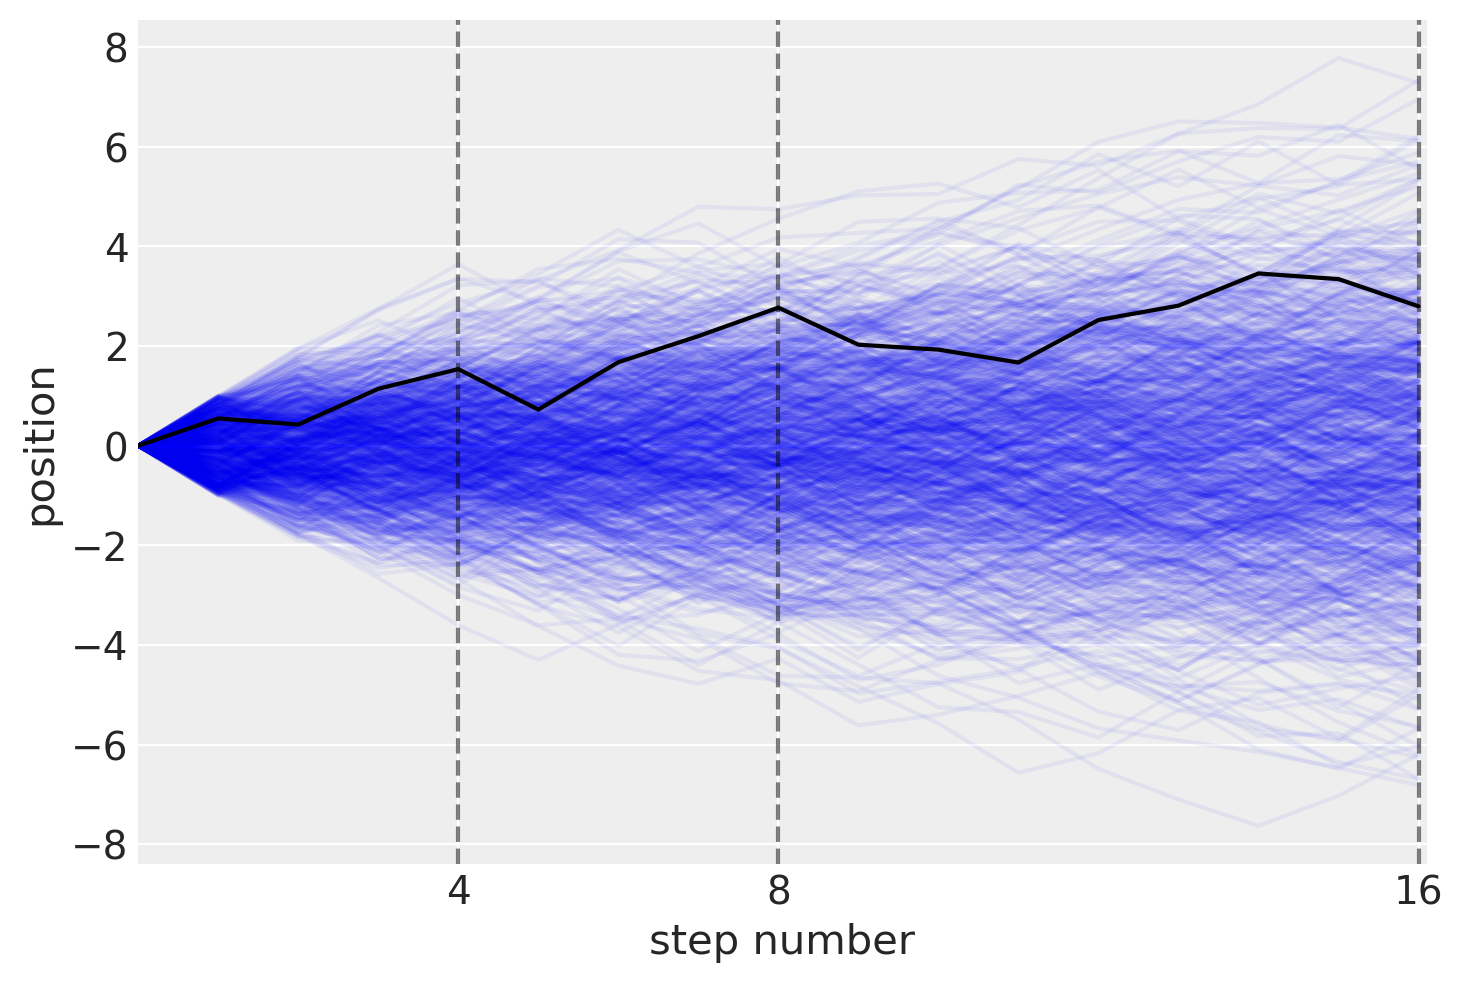

In [3]:
step_rng = np.random.default_rng(42)

steps = 16
repetitions = 1000
show_steps = [4, 8, 16]
x = np.zeros([steps + 1, repetitions])
for i in range(x.shape[1]):
    x[1:, i] = np.cumsum(step_rng.uniform(-1, 1, steps))

fig, ax = plt.subplots()
plt.plot(range(0, steps + 1), x[:, :], c="b", alpha=0.05)
plt.plot(range(0, steps + 1), x[:, 0], c="k")
for step in show_steps:
    plt.axvline(step, linestyle="--", c="k", alpha=0.5)

plt.xlabel("step number")
plt.ylabel("position")
ax.set_xticks(show_steps)
plt.xlim(0, step + 0.1)
plt.show()

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: ランダムウォークの図示</font></h3>

* -1から1までの一様分布から16個の値をサンプリングし、合計したものを16ステップ後の位置としています。
* それを100個繰り返しプロットしています。
* 0で埋められた行列Xを用意しのちに結果を格納します。
* ランダムに-1 or 1 をとる16ステップの合計をXの成分にループで格納していきます。
* Xのすべての成分(x[:, :])をプロットします。
* 一つ目のランダムウォークは別の黒線でプロットします。
* 元のコードにはplt.plotの中にrange()が入っていますが、なくても同じ図が出ます。  
  (この例では最初の引数をデータにしてもOK)
* 最後に4, 8, 16の破線を描きます。

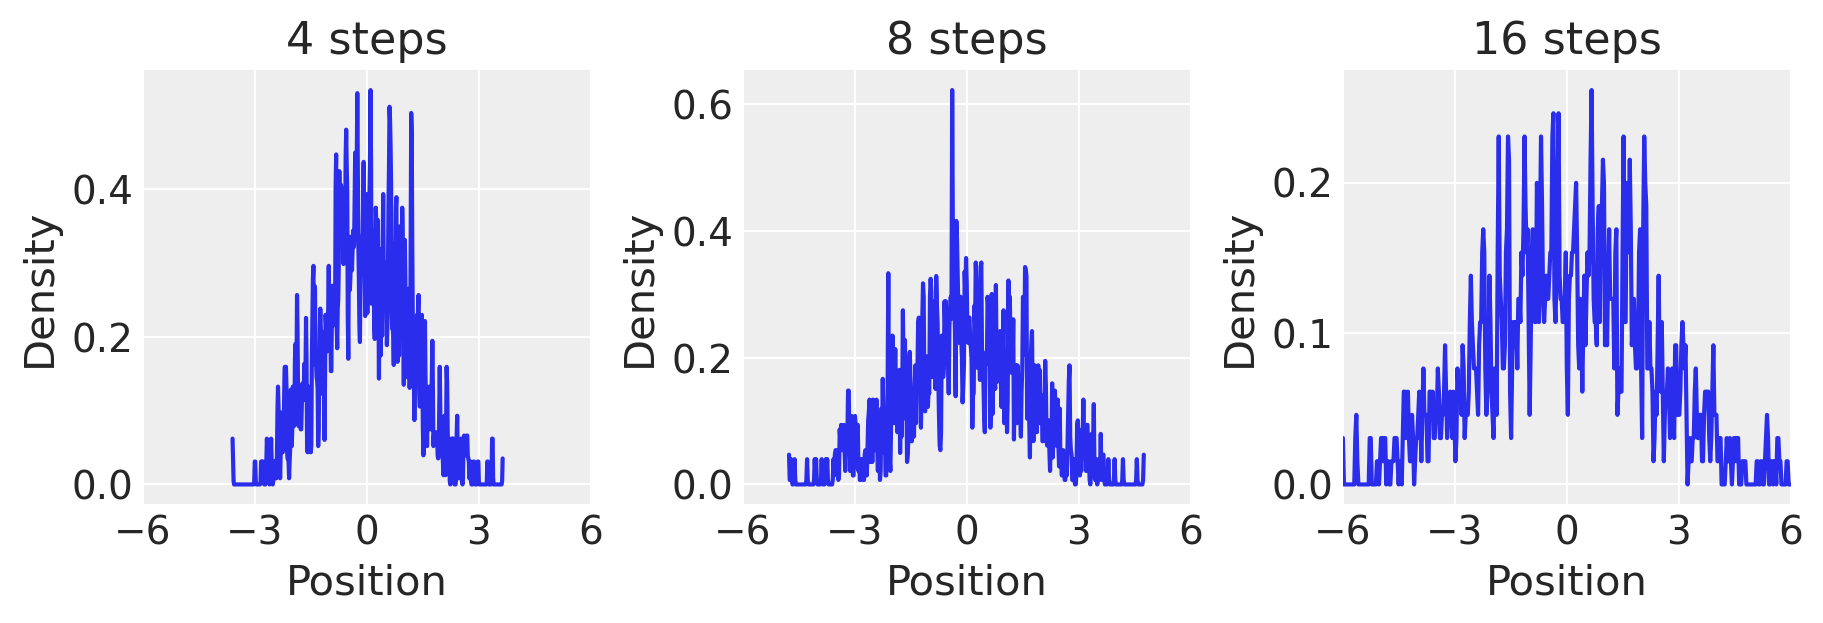

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True)

for step, ax in zip(show_steps, axs):
    az.plot_kde(x[step, :], bw=0.01, ax=ax)
    ax.set_title(f"{step} steps")
    ax.set_ylabel("Density")
    ax.set_xlabel("Position")
    ax.set_xlim(-6, 6)
    ax.set_xticks([-6, -3, 0, 3, 6])

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes:ステップ数と正規分布 </font></h3>

* １行に３列のサブプロットが並ぶように指定。
* sharex=Trueとしてサブプロットの軸が同じになるように設定。
* zip()関数を使用してリスト(タプルも可)から複数のイテラブルなオブジェクトを取り出す。  
  (show_stepsは4, 8, 16が入ったリストで、axsはサブプロットが入ったリスト。)  
  (そこから4-subplot1, 8-subplot2,...というように対応させている。)  
* azからplot_kde()関数、つまりカーネル密度関数をプロットする関数を呼び出す。  
  (x[step, :]より、すべてのstepごとにランダムウォークの結果xを取り出す。bwはバンド幅。)  
  (ax=axとしているのでzip()関数で取り出したものに含まれるaxにプロットされる。)  
  (この場合、ステップ4,8,16のどれかであればプロットされる)  
* 軸の調整をする。


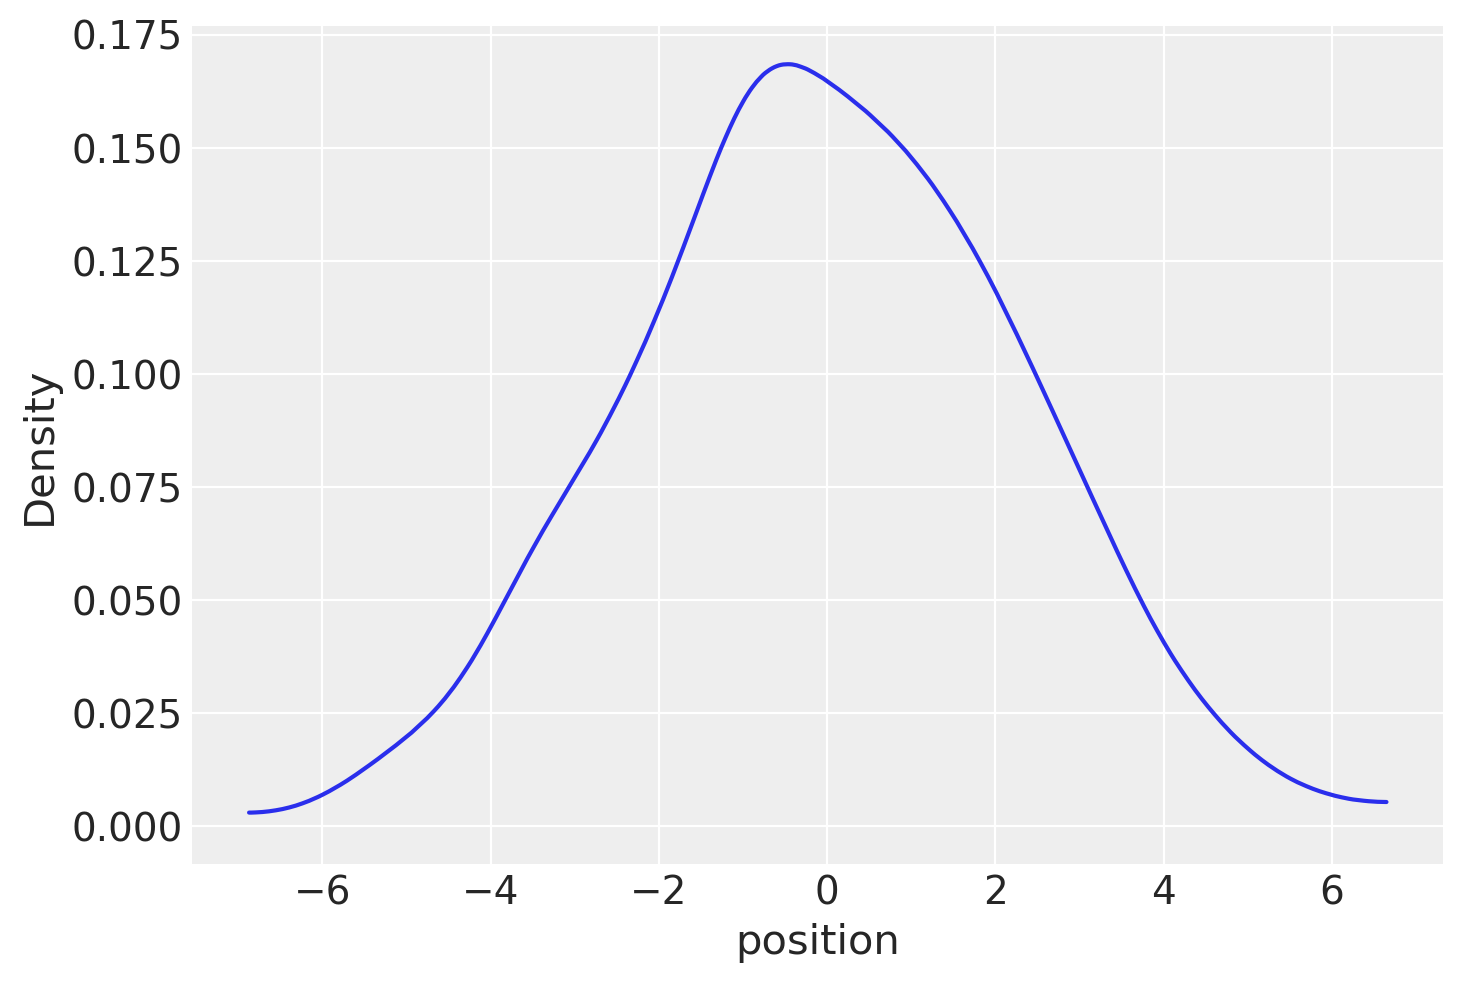

In [5]:
pos = rng.uniform(-1, 1, size=(16, 1000)).sum(0)
az.plot_kde(pos)
plt.xlabel("position")
plt.ylabel("Density");

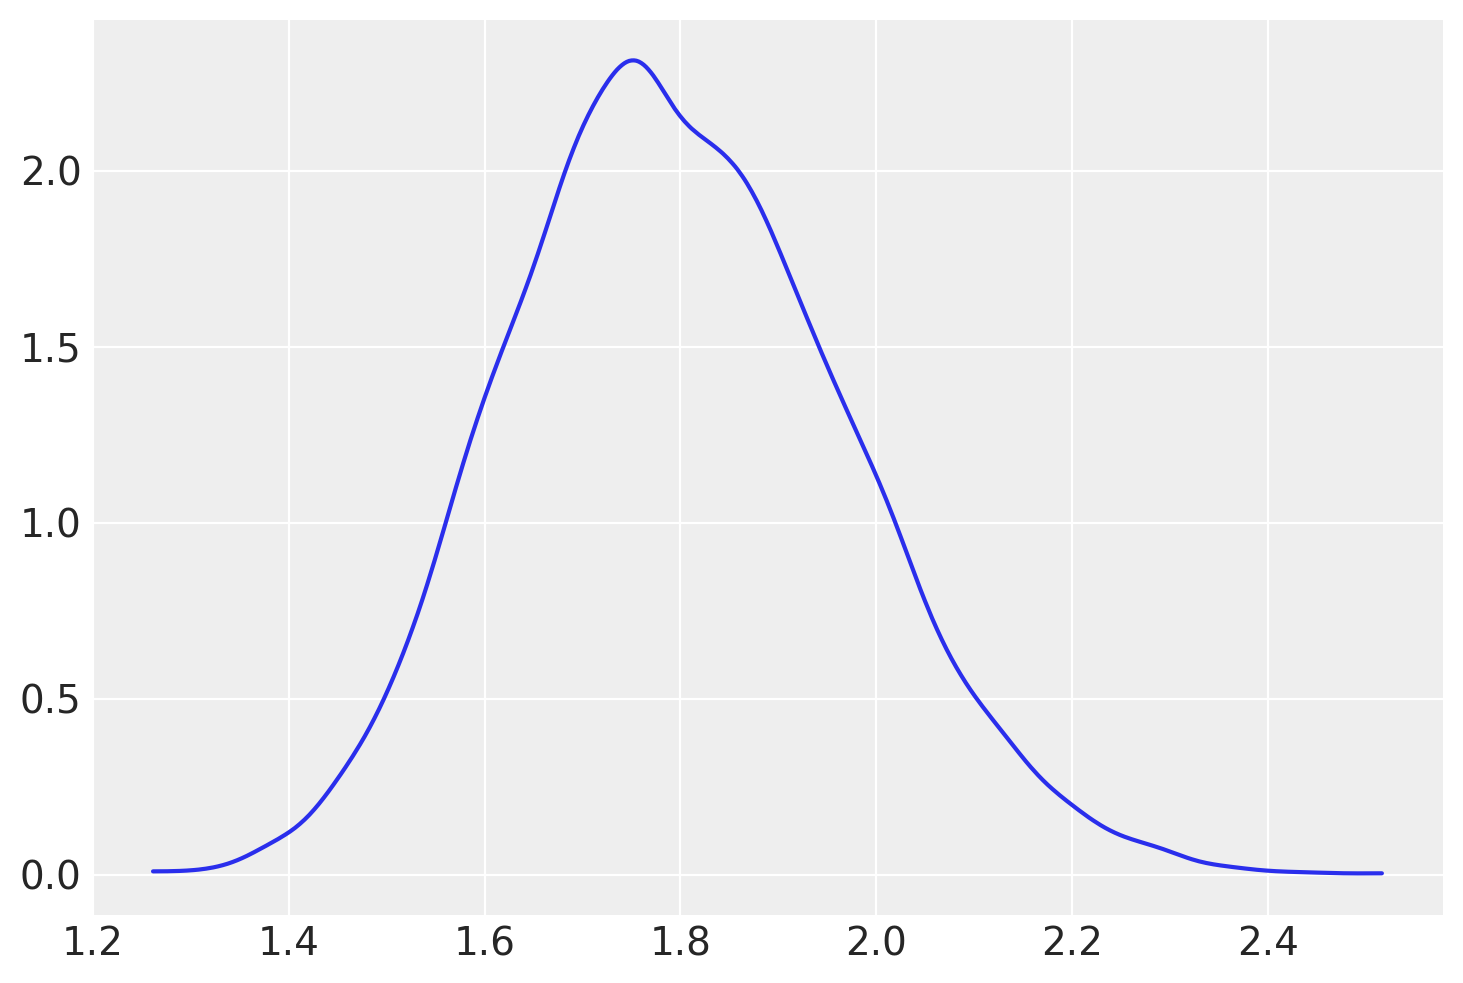

In [6]:
pos = rng.uniform(1, 1.1, size=(12, 10000)).prod(0)
az.plot_kde(pos);

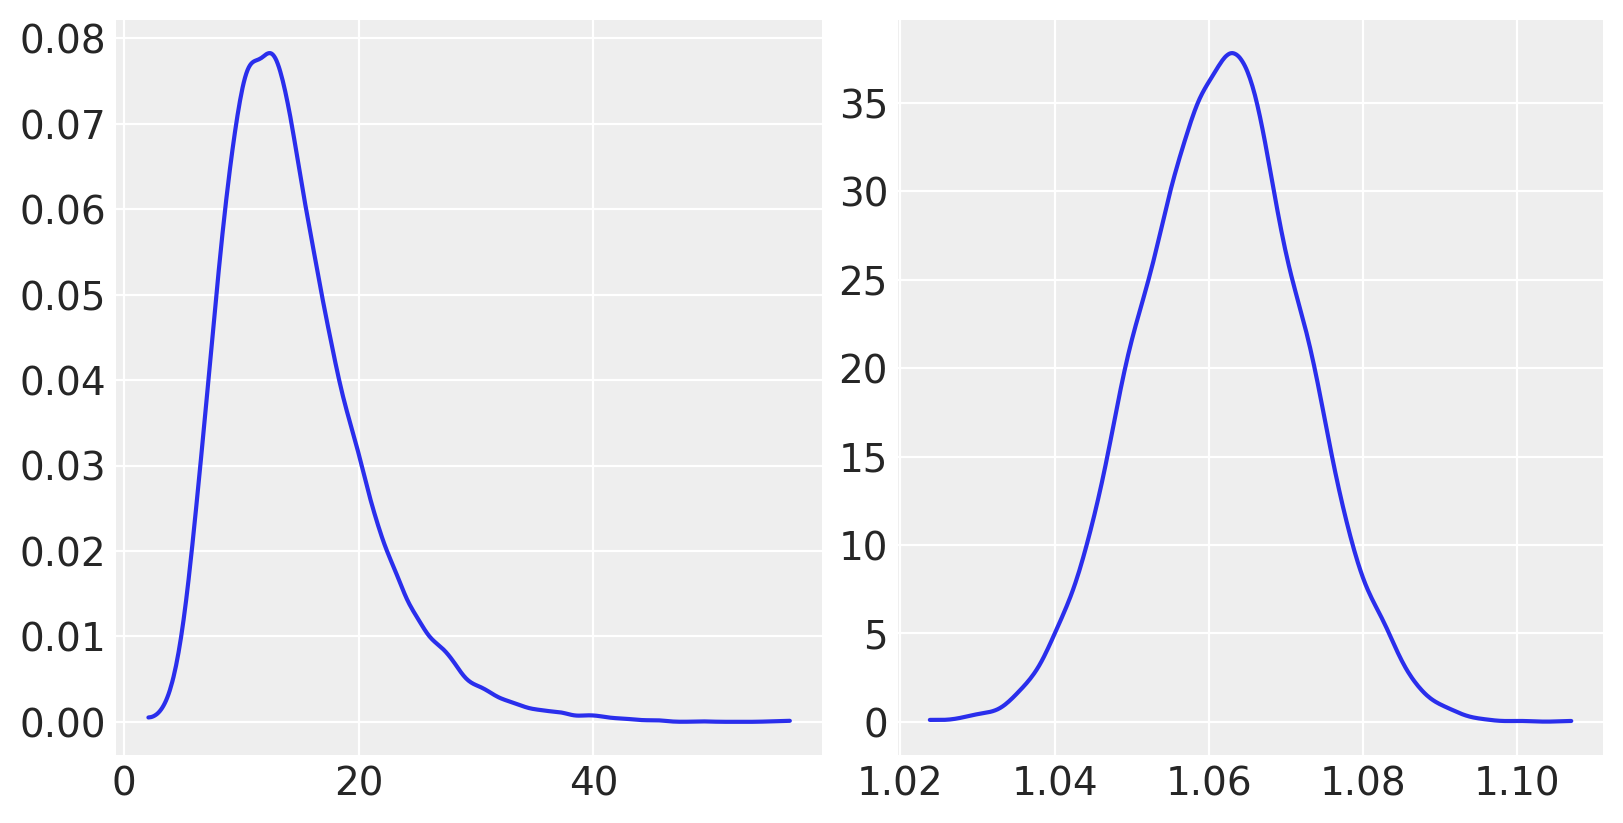

In [7]:
big = rng.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = rng.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes:標準偏差の大きさと正規分布 </font></h3>

* rngは最初に定義していた乱数を生成する関数。
* _, ax = plt.subplots()で、_はfigが入る部分を省略している。  
  このコードでは実際アンパック代入という操作を行っている。  
  plt.subplots()関数は図とサブプロットオブジェクトが入ったタプルを返す。  
  このタプルを本来はfig, axに対してそれぞれを割り当ててアンパック代入する。  
  ここではfigは必要ないので切り捨てている。
* az.plot_kde()は確率分布データのカーネル密度推定を行い、プロットを生成している。
  

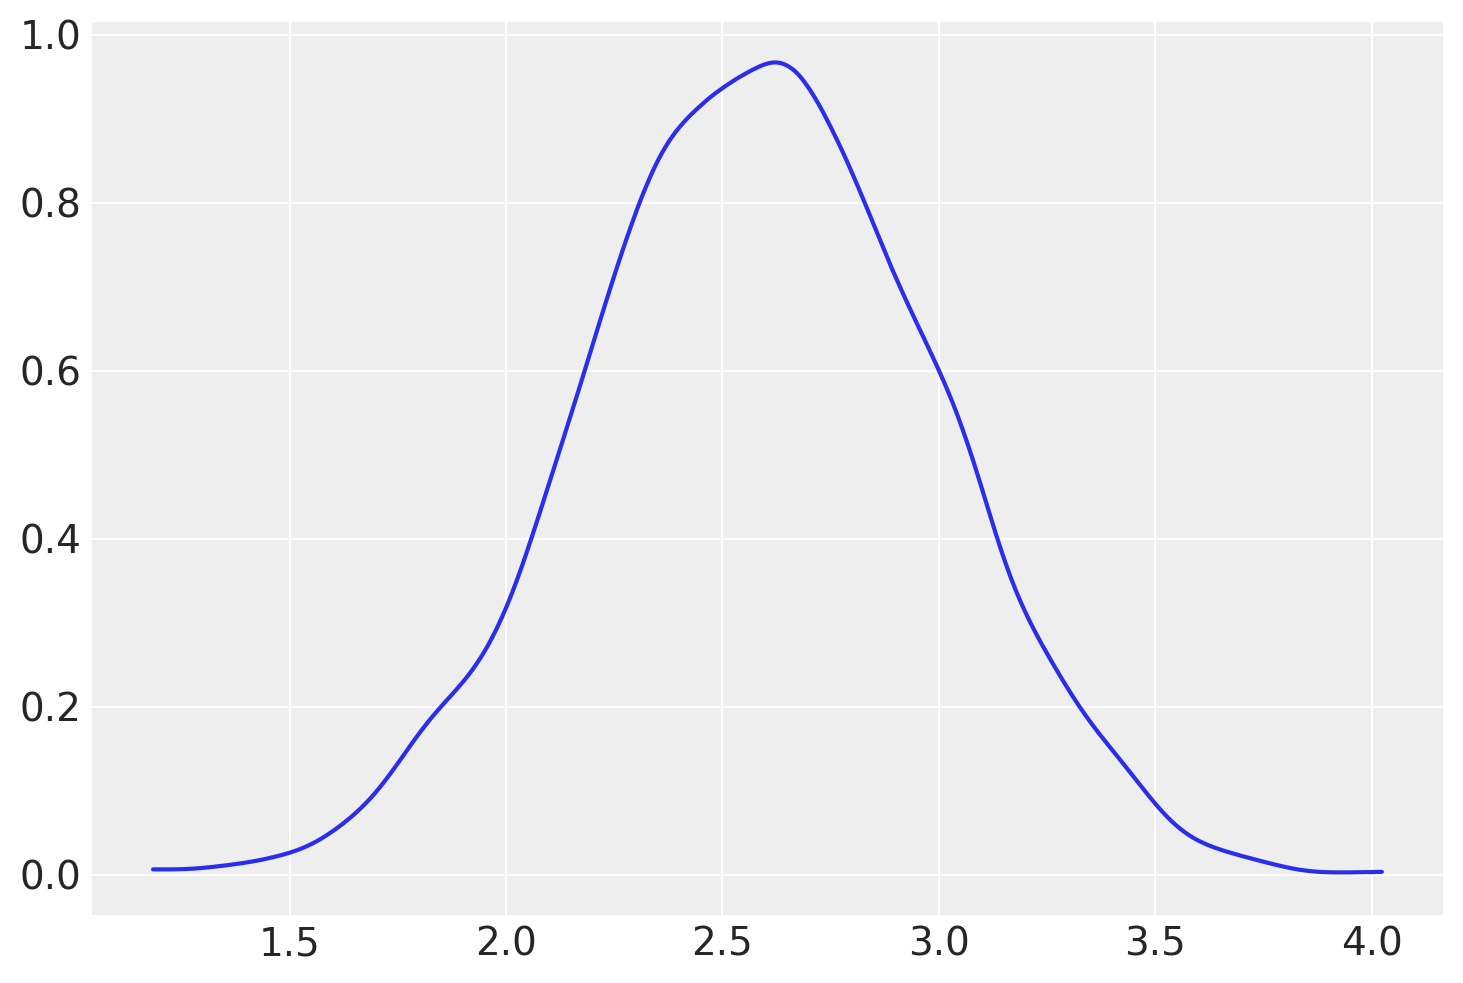

In [8]:
log_big = np.log(rng.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big);

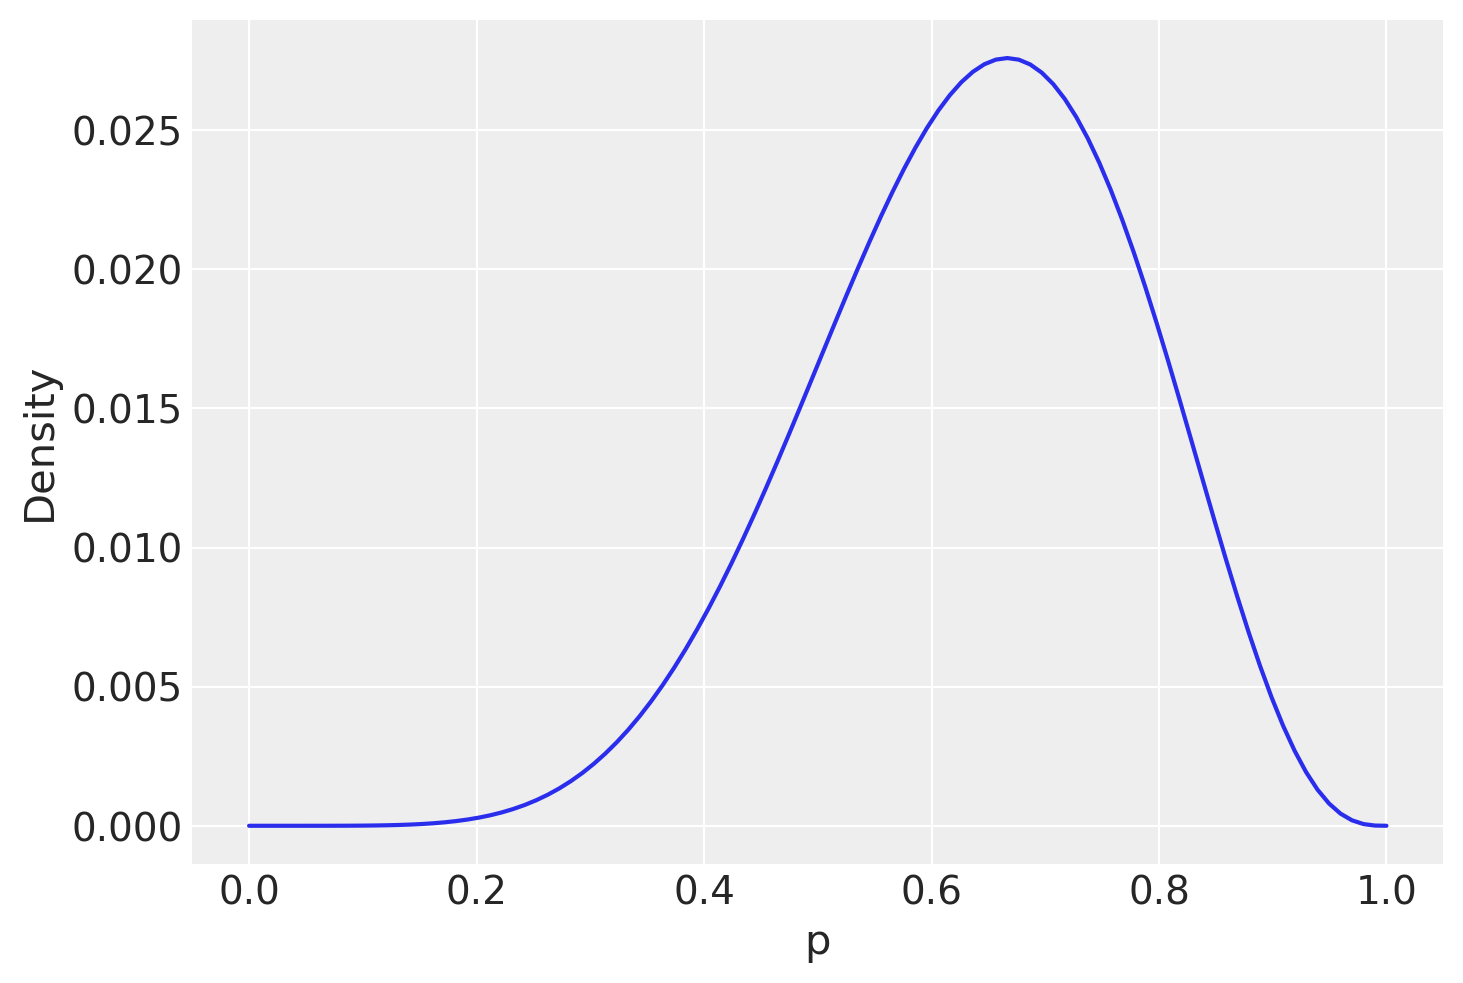

In [9]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior)
plt.xlabel("p")
plt.ylabel("Density");

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: 尤度と事前分布(確率)の積</font></h3>

* wという変数はpというパラメータを持つ二項分布に従い、pは0から1の一様分布に従うように事前分布を設定する。
* pの事後分布は尤度と事前分布の積に比例する。
* 尤度と事前分布をすべて足し合わせた平均尤度で割ると事後分布が得られる。

In [10]:
d = pd.read_csv("Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [11]:
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
height,138.264,27.602,90.805,170.180
weight,35.611,14.719,11.368,55.707
age,29.344,20.747,0.000,57.000
male,0.472,0.500,0.000,1.000


In [12]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

In [13]:
d2  = d[d.age >= 18]

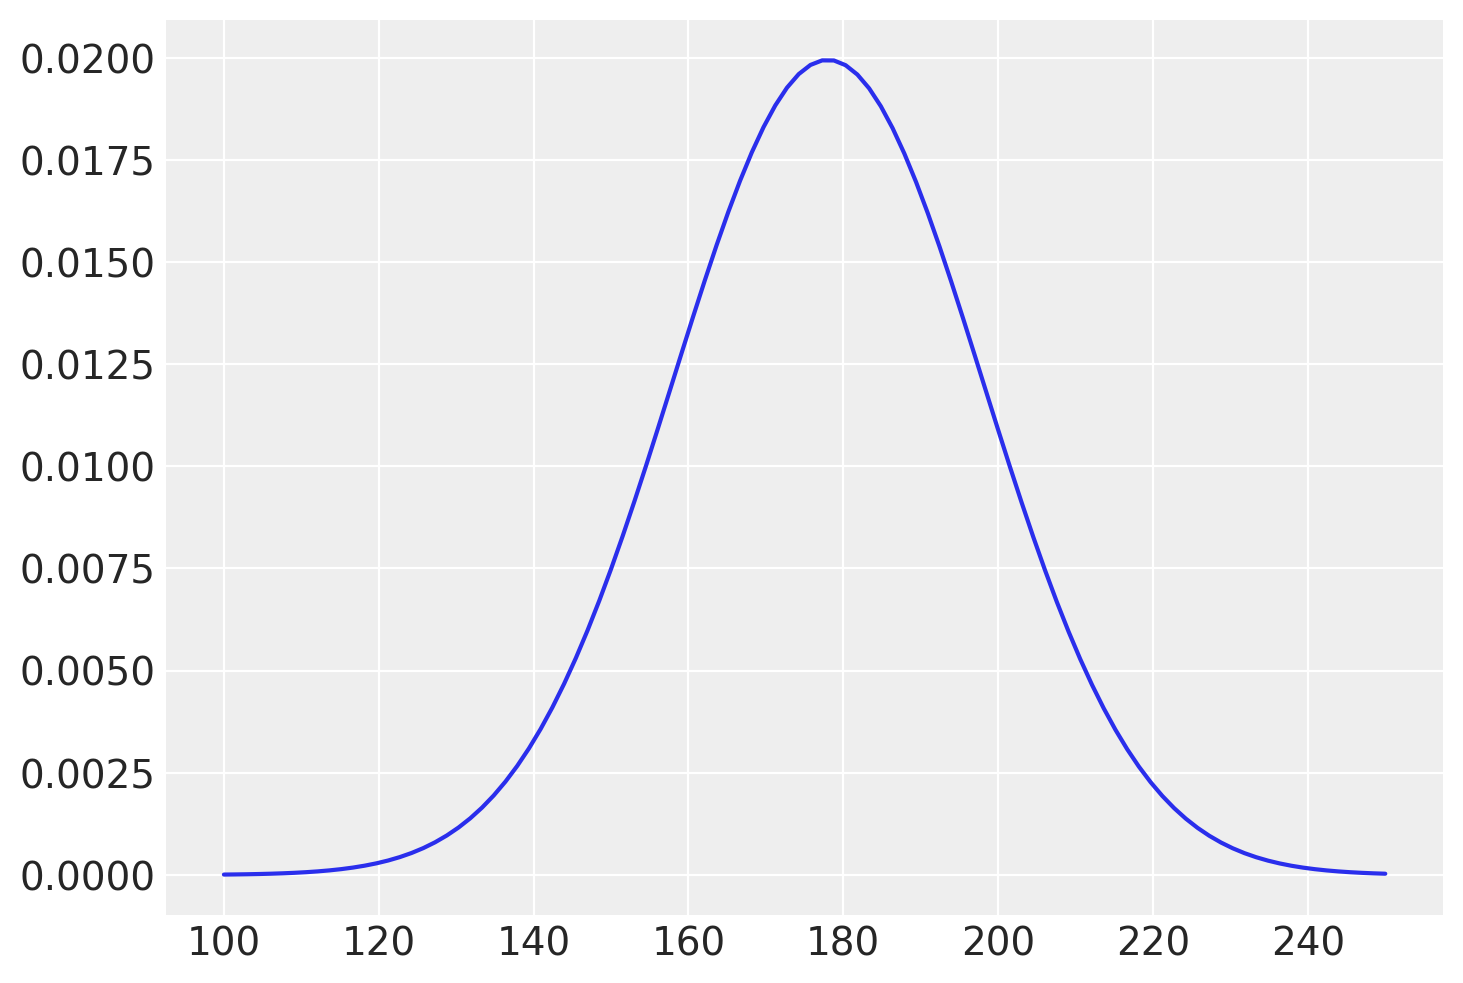

In [14]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20))

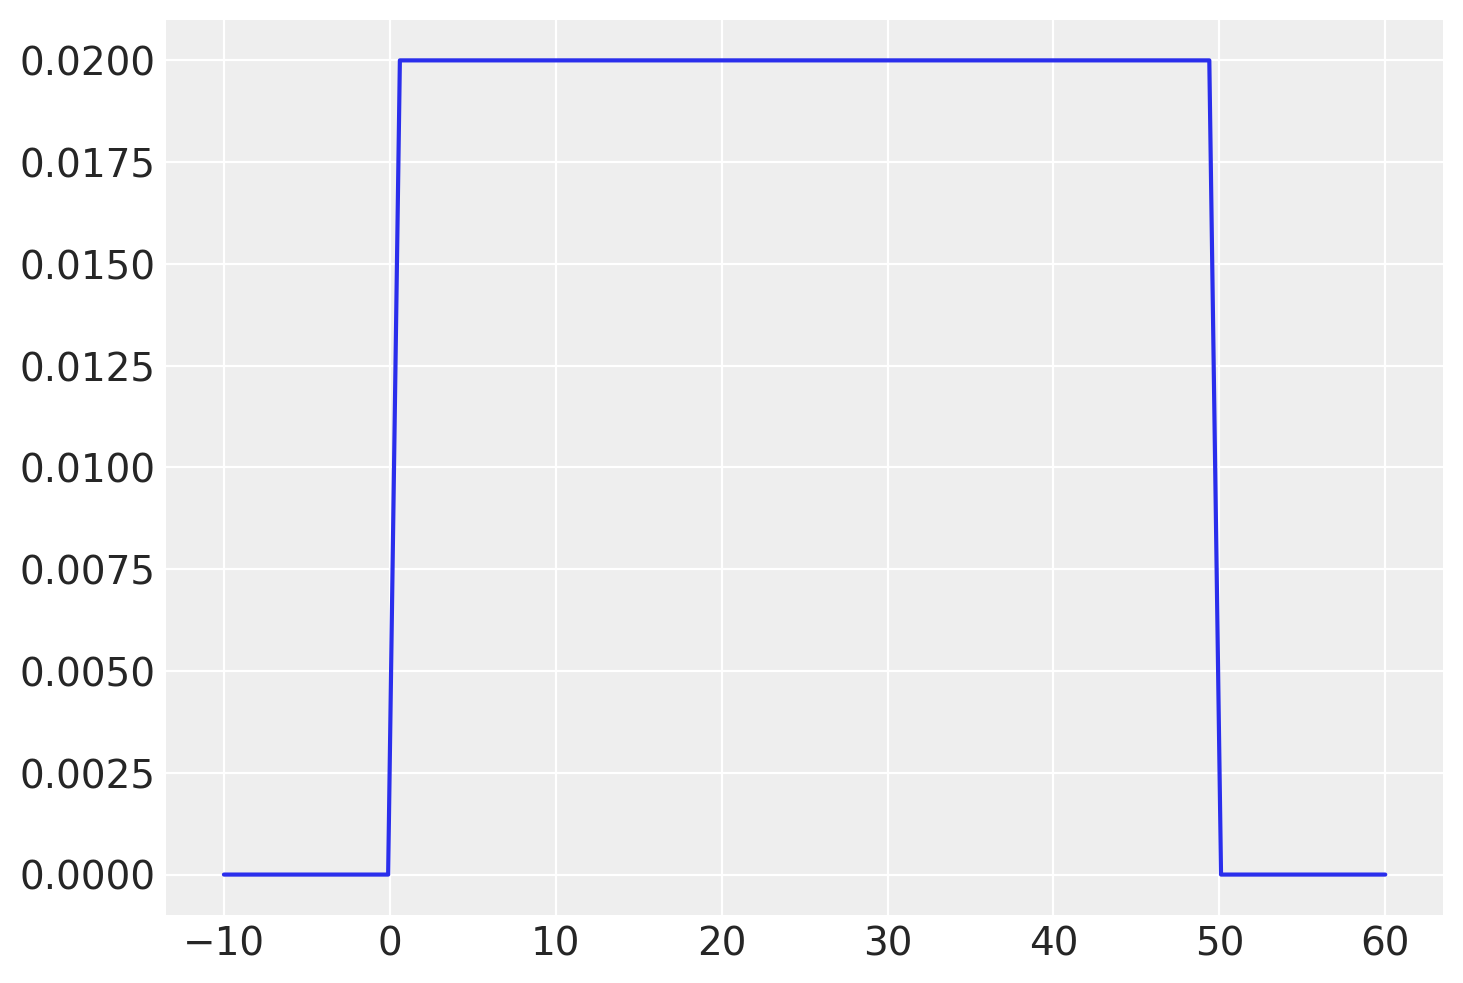

In [15]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50))

Text(0.5, 0, 'heights')

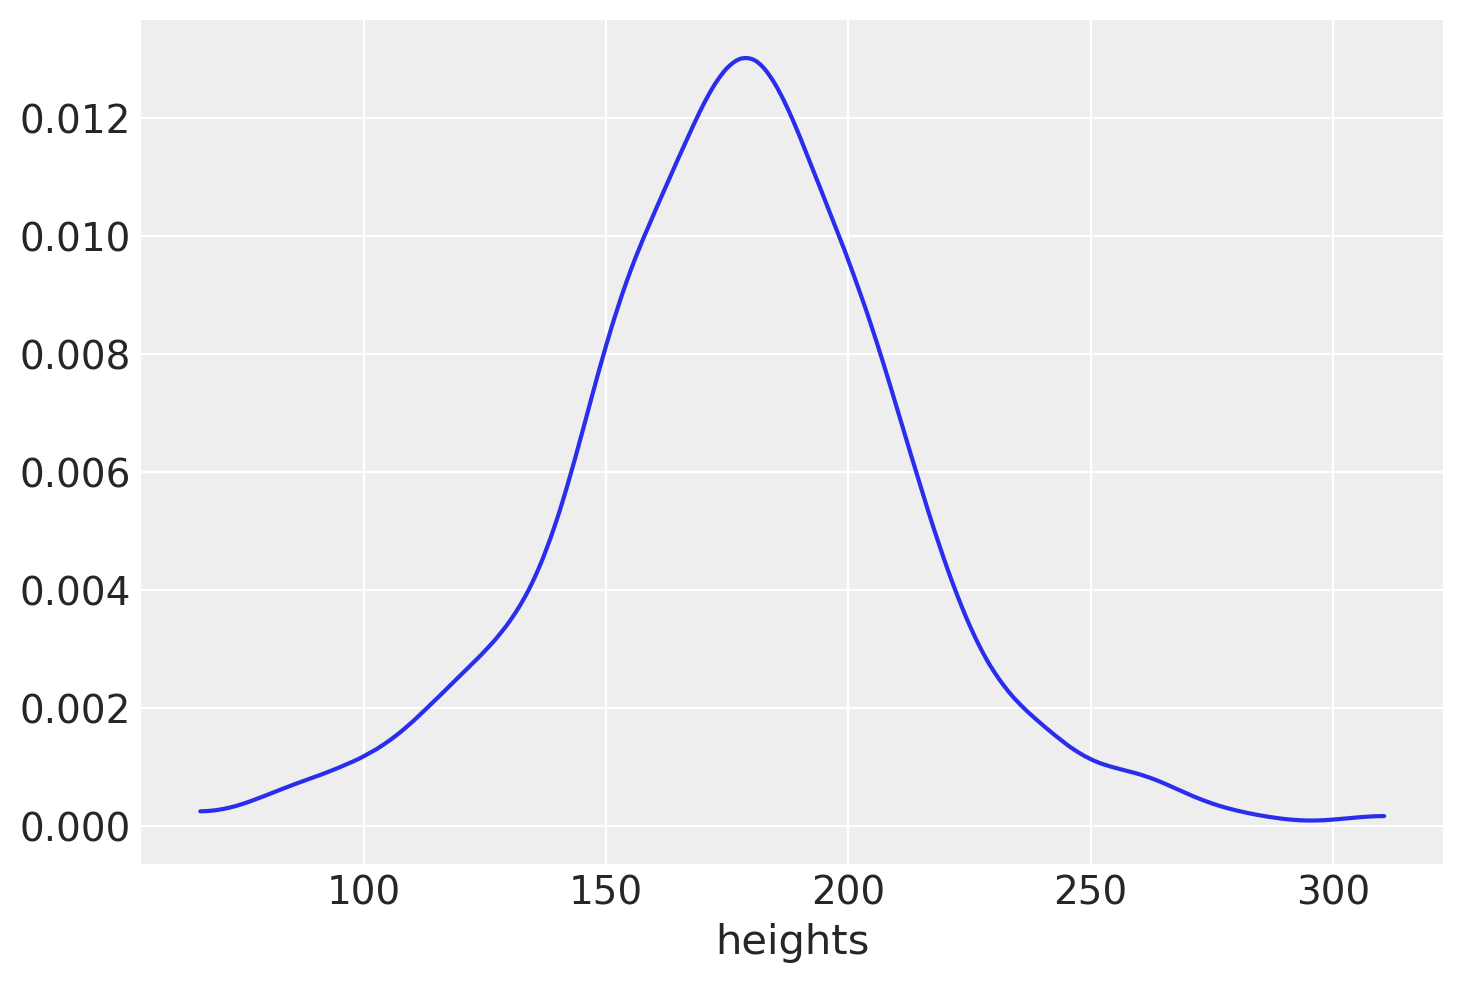

In [16]:
n_samples=1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")

([], [])

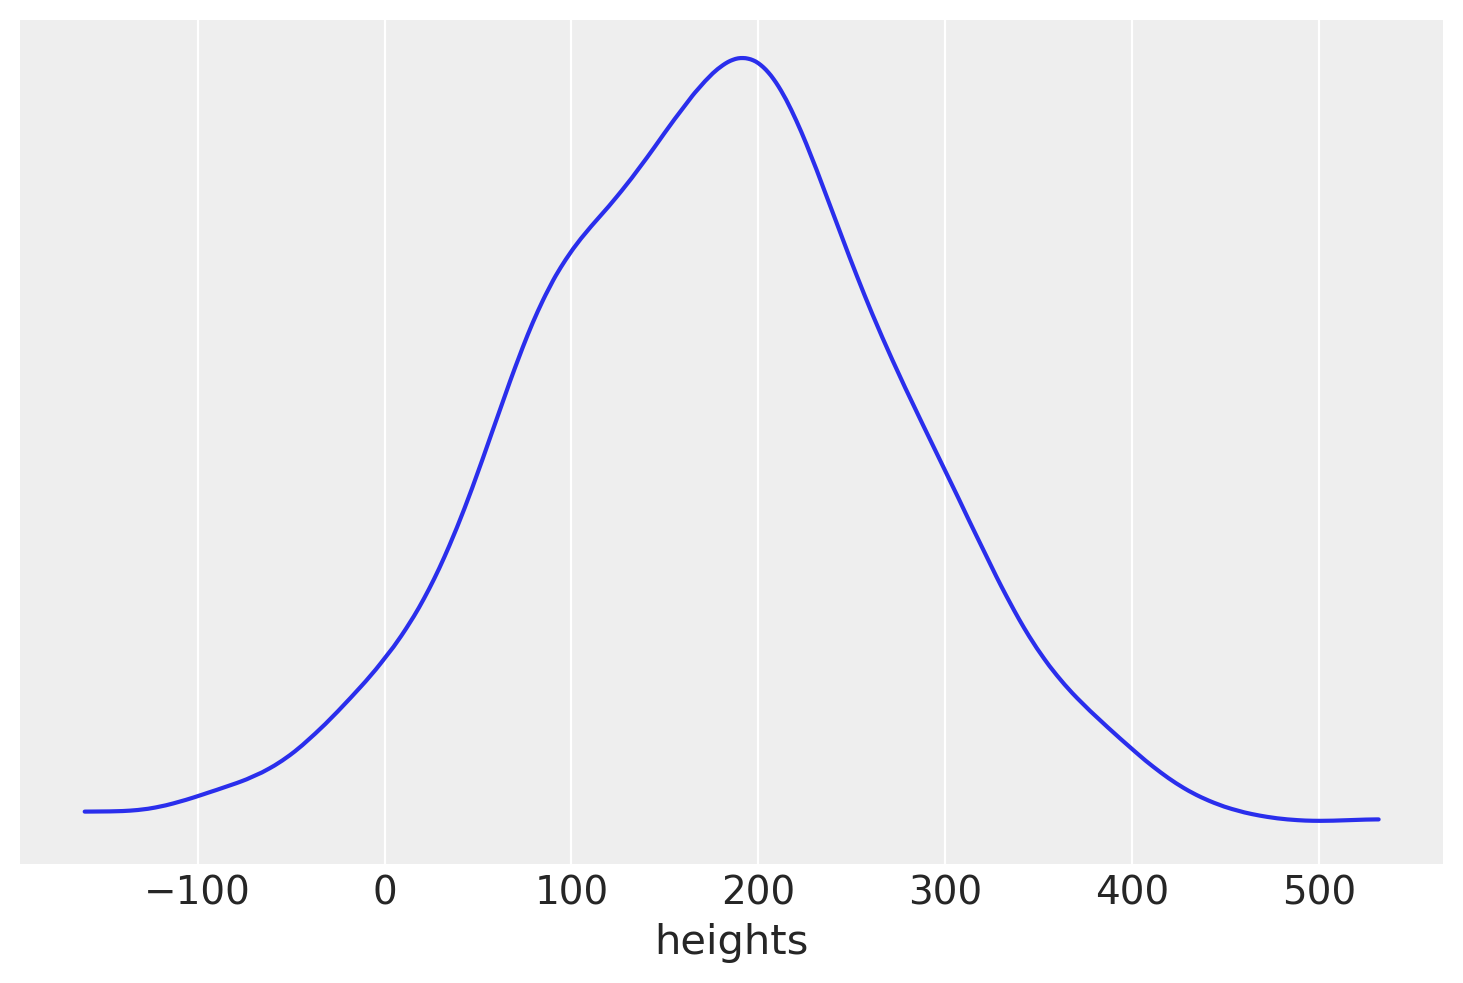

In [17]:
n_samples=1000
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")
plt.yticks([])

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: 事前分布の形</font></h3>

* 事前分布を自分の知識や経験から設定するとき、ありえない値をとる確率が高いなど、  
  適切でない分布になっていないかプロットをして確かめるとよい。

In [18]:
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2,-1).T
likelihood =[
     sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i]))
     for i in range(len(post))
 ]

post_prod = (
    likelihood
    + stats.norm.logpdf(post[:,0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:,1], loc=0, scale=50)
)
post_prob = np.exp(post_prod - max(post_prod))

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: 事後分布のグリッド近似</font></h3>

* 教科書で計算の詳しい説明はのちに行われる。
* np.mgridを使用して生成されるグリッドは、通常、2次元の配列として生成される。
* np.mgrid[150:160:0.05, 7:9:0.05]  の例、
  
    ```
    array([[[150.00, 150.00, 150.00, ..., 150.00, 150.00, 150.00],
            [150.05, 150.05, 150.05, ..., 150.05, 150.05, 150.05],
            ...,
            [160.00, 160.00, 160.00, ..., 160.00, 160.00, 160.00]],
   
           [[7.00, 7.05, 7.10, ..., 8.85, 8.90, 8.95],
            [7.  , 7.05, 7.1 , ..., 8.85, 8.9 , 8.95],
            ...,
            [7.00, 7.05, 7.10, ..., 8.85, 8.90, 8.95]]])
    ```
    
* np.mgrid[150:160:0.05, 7:9:0.05].reshape(2,-1)の例、

    ```
    array([[150.  , 150.05, 150.1 , ..., 159.9 , 159.95, 160.  ],
          [  7.  ,   7.  ,   7.  , ...,   8.95,   8.95,   8.95]])

    ```
* np.mgrid[150:160:0.05, 7:9:0.05].reshape(2,-1).Tの例、

    ```
   array([[150.  ,   7.  ],
       [150.05,   7.  ],
       [150.1 ,   7.  ],
       ...,
       [159.9 ,   8.95],
       [159.95,   8.95],
       [160.  ,   8.95]])


    ```
* loc=post[:,0][i], scale=post[:,1][i]はpostから一列ずつ取り出してfor ループでi番目の値を適用している。
* 全部対数化されているので事後分布は加算で表現できる。
\begin{align*}
\text{post\_prod} &= \text{likelihood} \\
&\quad + \sum_{i=1}^{N} \left(\log \left(\frac{1}{\sqrt{2\pi \cdot 20^2}} \cdot \exp\left(-\frac{(x_i - 178)^2}{2 \cdot 20^2}\right)\right)\right) \\
&\quad + \sum_{i=1}^{N} \left(\log \left(\frac{1}{50} \cdot I(0 \leq x_i \leq 50)\right)\right) \\
\text{post\_prob} &= \exp\left(\text{post\_prod} - \max(\text{post\_prod})\right)
\end{align*}

* 最大値を引くことにより、確率密度関数全体が最大値を持つ点を0にシフトし、他の点との相対的な確率密度を保つ。

In [19]:
post_prob

array([1.95774597e-35, 9.71687726e-35, 4.50228456e-34, ...,
       3.99523704e-31, 5.09561418e-31, 6.33163222e-31])

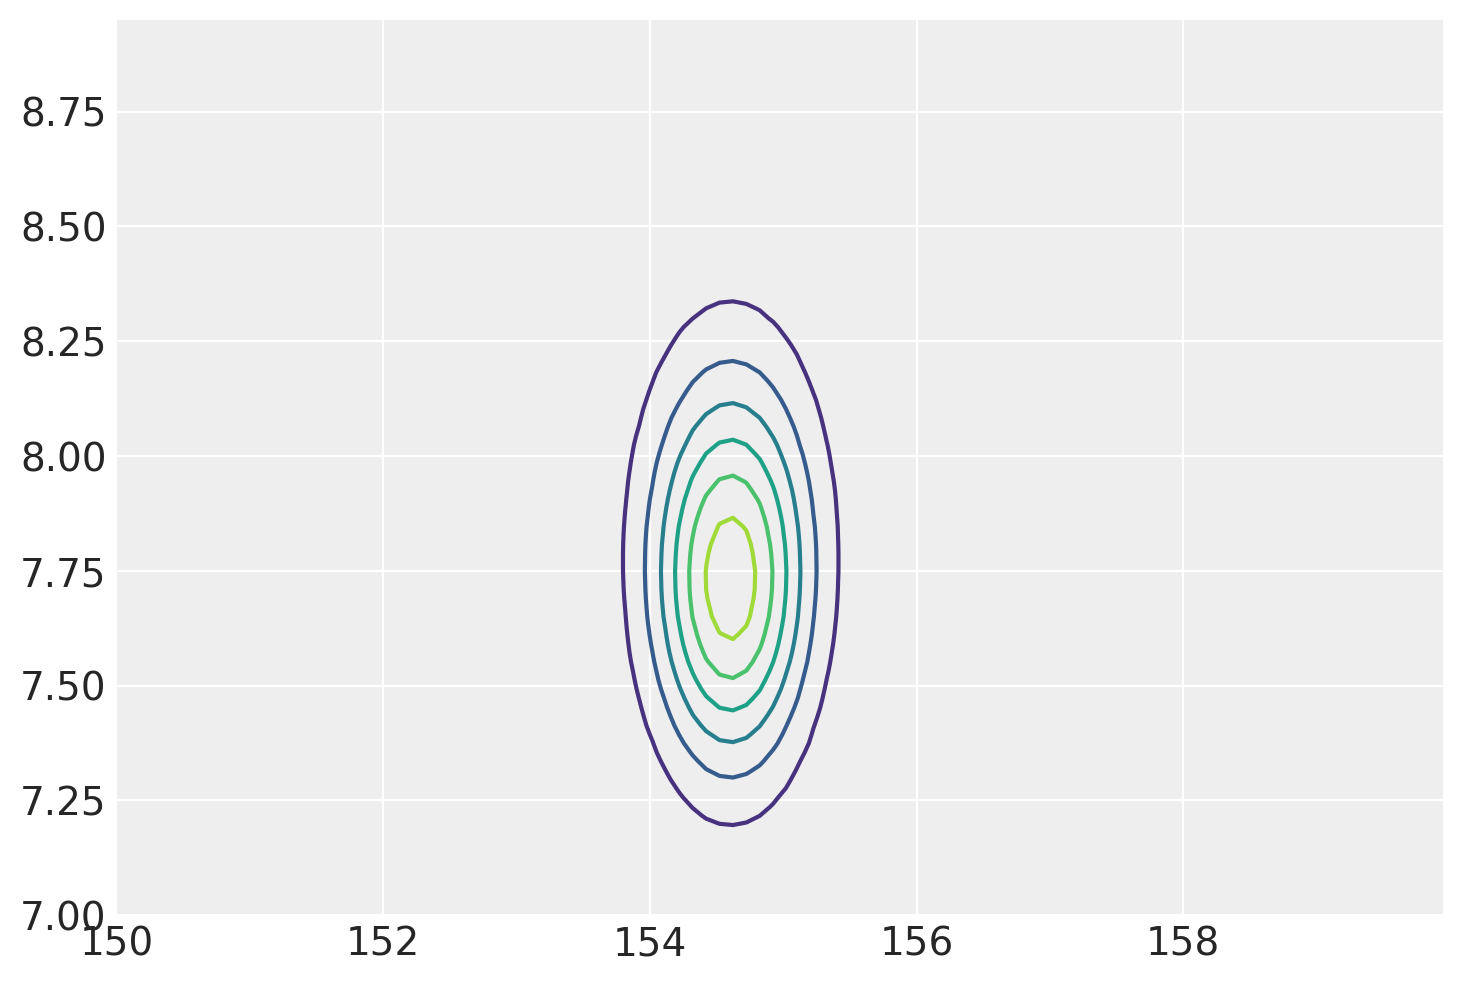

In [20]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None, :], yi[:,None]))
plt.contour(xi, yi, zi)

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: 事後分布の等高線プロット</font></h3>

* np.linspace()は、post 配列から最小値から最大値までの範囲を等間隔で分割し、100個の均等な間隔の数値を取り出す。  
  (これは等高線の図の軸となる)
* griddata()は、各データ点((post[:,0], post[:,1]))に対応する値(post_prob)を得ると値の間を滑らかに補間する。  
* さらにそれを新しい軸((xi[None, :], yi[:,None]))に対応させ、ziとして返す。  
  (なお1次元の xiとyi 配列は各軸の座標を表しているが、グラフを描画するときには、  
  これらを2次元の座標空間に配置する必要があるため、2次元の行列（行列形式）に変換されている。)
* xi[None, :] はNumPyで、1次元の配列xiを2次元の配列に変換する操作。
* 例えば、
   ```
  xi = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
   ```
  に対して、
  ```
  xi[None, :]
  ```
  とすると
   ```
  array([[1.0, 2.0, 3.0, 4.0, 5.0]])
   ```
   が出力される。
* [[1.0, 2.0, 3.0, 4.0, 5.0]]は、1つのリストとその中にさらにリストがある。  
  (外側のリストは行（または次元）、内側のリストは列（または要素）を表現している。)  
  (例えば、行列の要素にアクセスする場合は、data[0] で外側のリストにアクセスし、data[0][2] のように内側のリストにアクセスできる。)  
* これでxi を行ベクトルに変換したことになる。yiについても同様。
* plt.contour() は等高線を図示する関数。

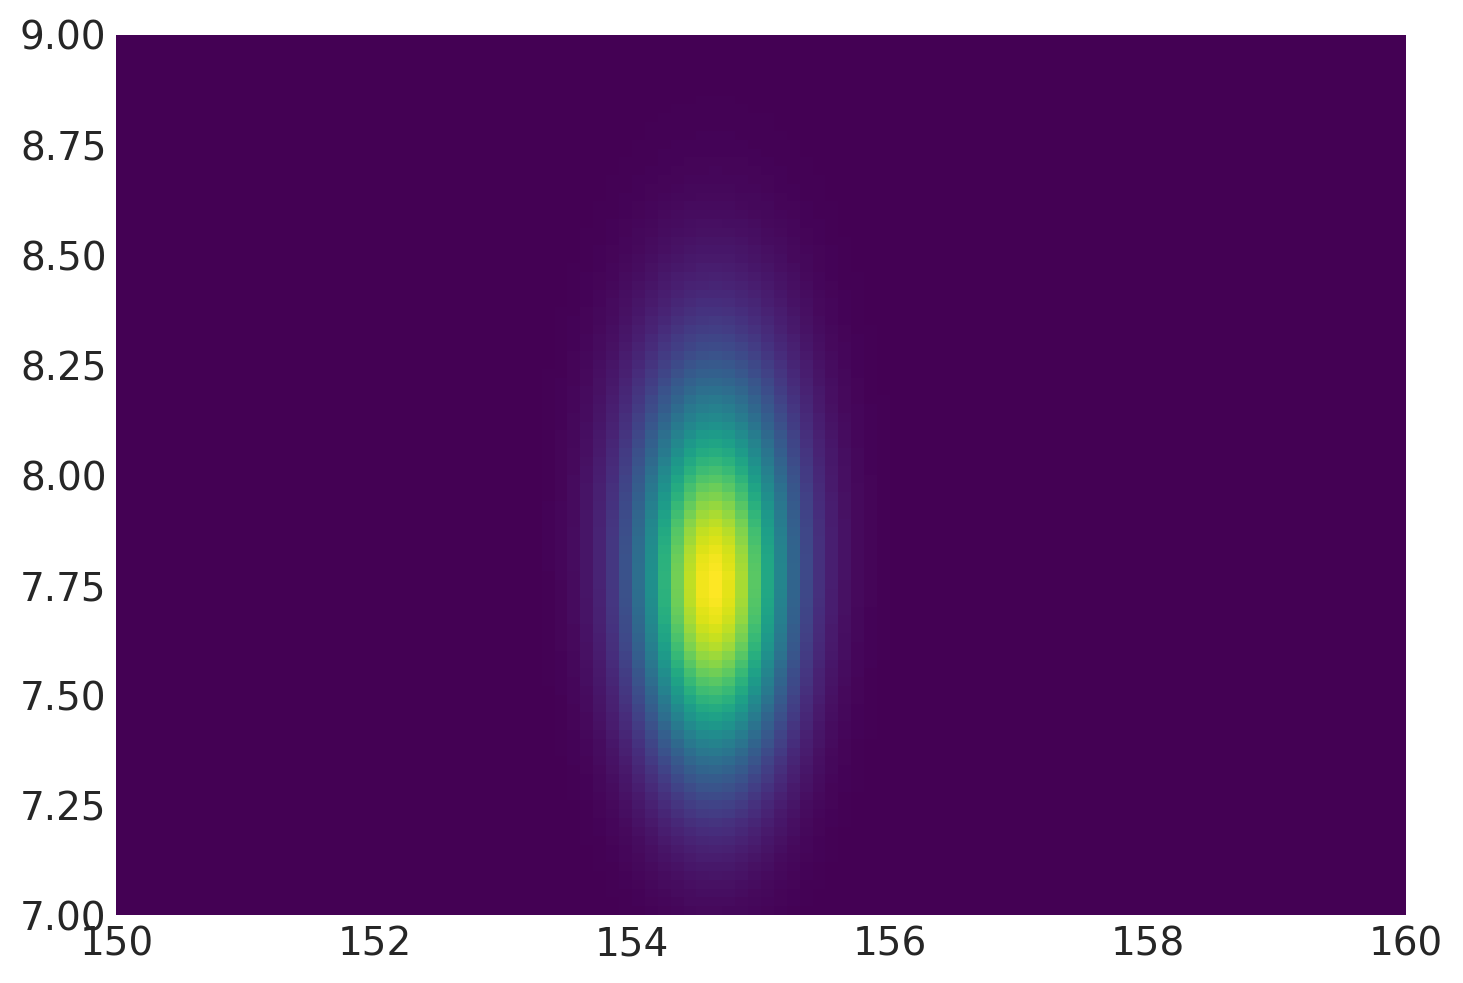

In [21]:
ax = plt.subplot()
ax.imshow(zi, origin = "lower", extent=[150.0, 160.0, 7, 9], aspect="auto")
ax.grid(False)

Text(0, 0.5, 'sample_sigma')

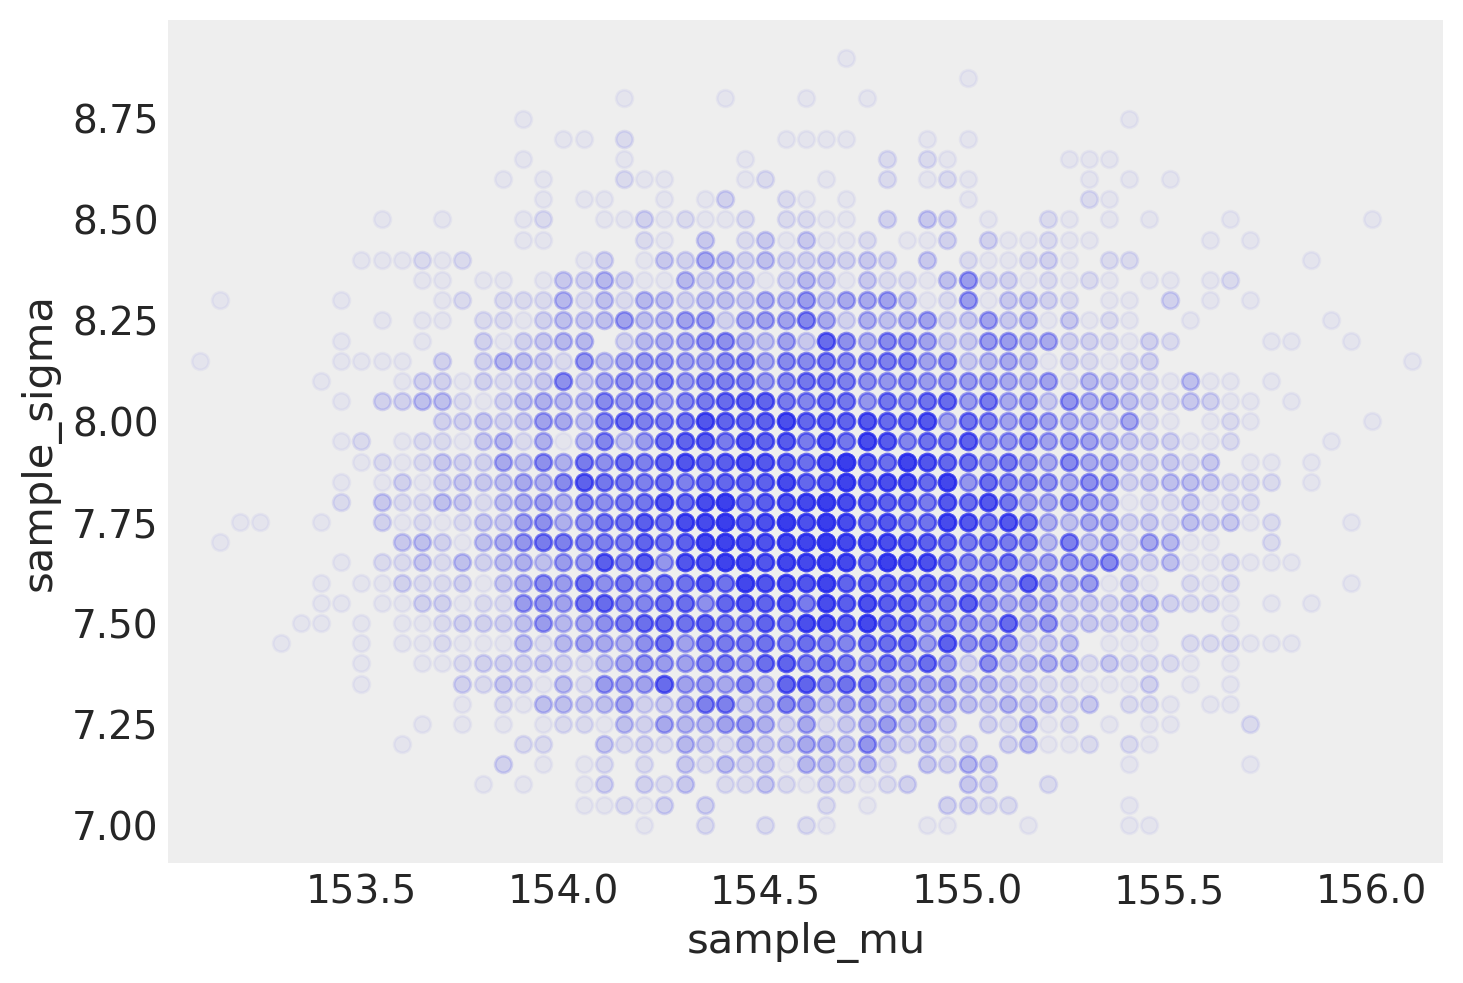

In [22]:
sample_rows = rng.choice(
    np.arange(len(post)), size = 10000, replace=True, p=(post_prob/post_prob.sum())
)
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]
plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma")

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: 事後分布の散布図のプロット</font></h3>

* samle_rows以下はより簡潔なコードで以下のように書ける、
  ```
  samples = post[sample_rows]  # sample_muとsample_sigmaを一度に取得
  plt.scatter(*samples.T, alpha=0.05)  # 'o'はデフォルトマーカー
  plt.axis("equal")
  plt.grid(False)
  plt.xlabel("sample_mu")
  plt.ylabel("sample_sigma")
  ```
* np.arange(len(post)) はpostの各データポイントに対応する整数のインデックスのリストを生成する。  
  (np.arange()はpostの長さ範囲について等間隔な数値リストを作成する)  
  (整数のリストであればrang_choiceの引数になるのでlist(range(1, 7))などでも可)  
  (ちなみにrange(1,7)は1から6までの整数、つまりサイコロの目などの範囲を指定する)
* postは
  ```
  array([[150.  ,   7.  ],
       [150.  ,   7.05],
       [150.  ,   7.1 ],
       ...,
       [159.95,   8.85],
       [159.95,   8.9 ],
       [159.95,   8.95]])
  ```
  という配列になっている。
* sample_mu = post[:,0][sample_rows]とsample_sigma = post[:,1][sample_rows]では、  
  postからそれぞれ1列目、2列目の中から、sample_rowsで選ばれた値だけを取り出して格納しなおしている。  
  取り出された結果は、10000個値を並べたarrayになっている。
* 一方、samples = post[sample_rows]では、分けることなく同時に取り出している。
  これは10000行2列のarrayとなっている。
* 簡略化したコードでは、plt.scatter(*samples.T, alpha=0.05)としている。
* samles.Tは、
  ```
  array([[153.95, 155.35, 153.9 , ..., 154.7 , 154.7 , 153.85],
       [  7.7 ,   7.65,   8.15, ...,   8.1 ,   7.5 ,   7.6 ]])
  ```
  のような形をしている。  
 
* *samples.Tとすると1行目をx軸、2行目をy軸としてアンパックし、plt.scatter()に引数として渡している。
  

Code 4.21

[]

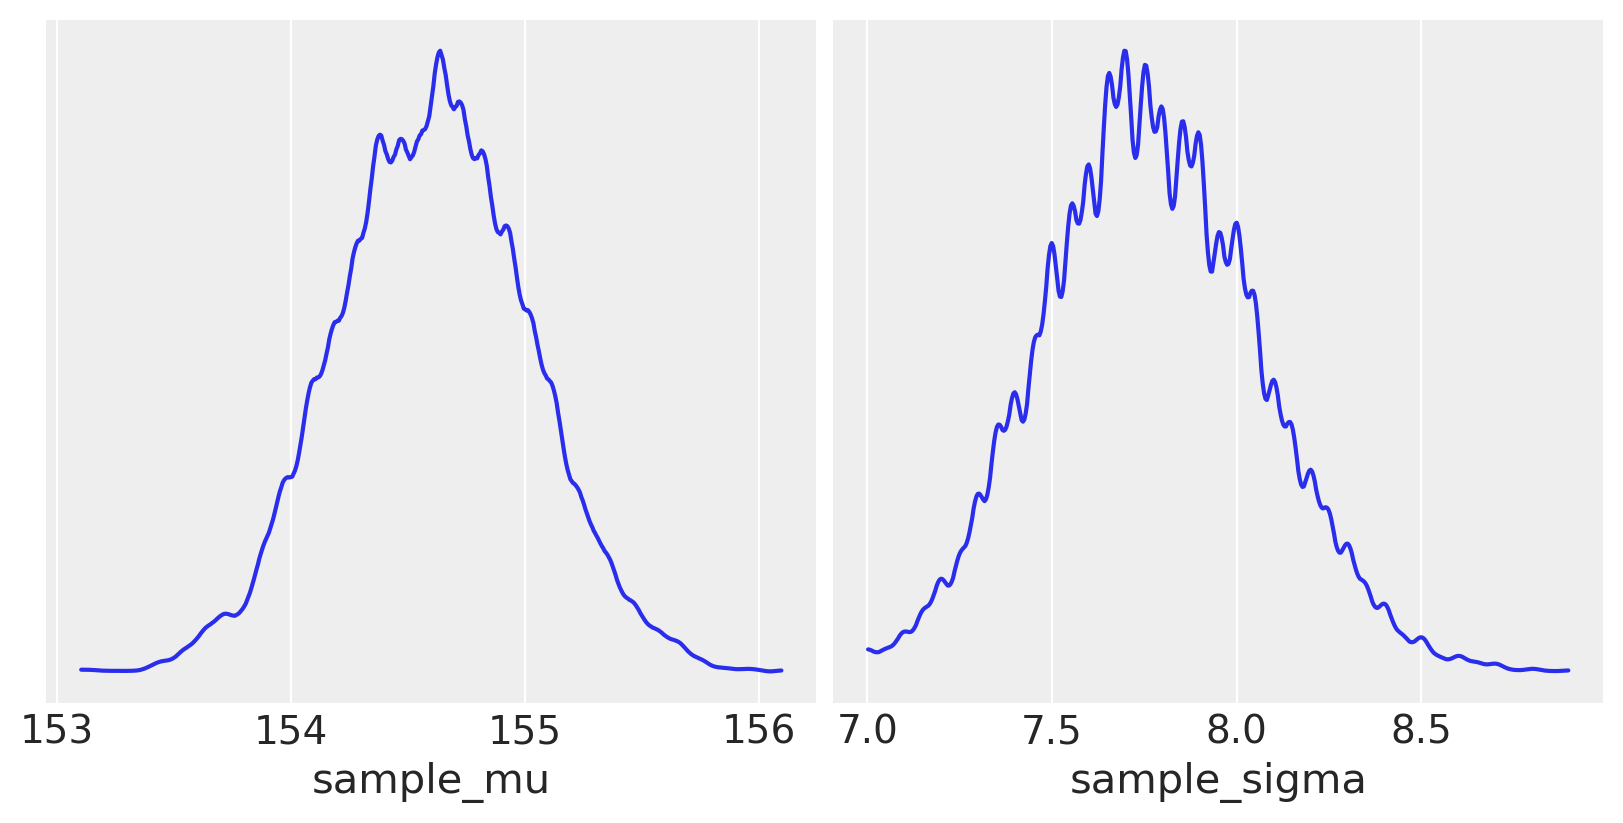

In [23]:
_, ax = plt.subplots(1, 2, figsize=(8,4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel("sample_mu")
az.plot_kde(sample_sigma,ax=ax[1])
ax[1].set_xlabel("sample_sigma")
ax[0].set_yticks([])
ax[1].set_yticks([])

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: パラメータの分布</font></h3>

* より簡潔に以下のコードでも書ける
  ```
   fig, axs = plt.subplots(1, 2, figsize=(8, 4))

   for ax, data, xlabel in zip(axs, [sample_mu, sample_sigma], ["sample_mu",     "sample_sigma"]):
    az.plot_kde(data, ax=ax)
    ax.set(xlabel=xlabel, yticks=[])
   ```

In [24]:
az.hdi(sample_mu),az.hdi(sample_sigma)

(array([153.9, 155.2]), array([7.3, 8.2]))

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: パラメータの最高密度区間</font></h3>

In [25]:
d3 = rng.choice(d2.height, 20)

In [26]:
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2,-1).T

likelihood2 = [
    sum(stats.norm.logpdf(d3, loc=post2[:, 0][i], scale=post2[:, 1][i])) for i in range(len(post2))
]

post_prod2 = (
    likelihood2
    + stats.norm.logpdf(post2[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post2[:, 1], loc=0, scale=50)
)

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = rng.choice(
    np.arange(len(post2)), size=10000, replace=True, p=(post_prob2 / post_prob2.sum())
)
sample_mu2 = post2[:, 0][sample_rows2]
sample_sigma2 = post2[:, 1][sample_rows2]

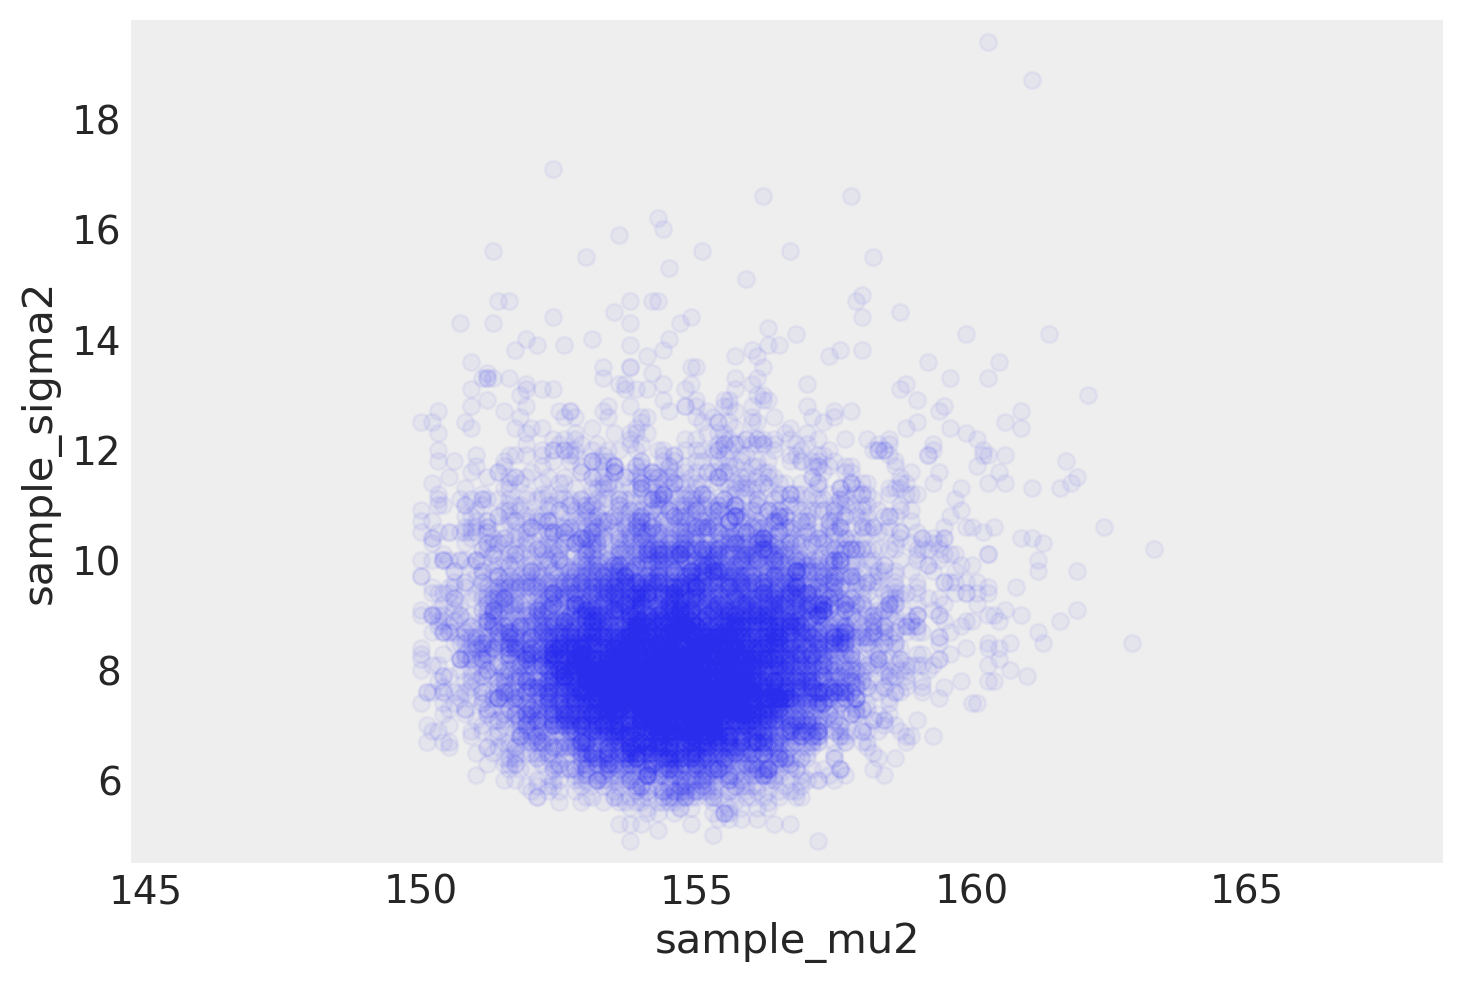

In [27]:
plt.plot(sample_mu2, sample_sigma2, "o", alpha=0.05)
plt.axis("equal")
plt.xlabel("sample_mu2")
plt.ylabel("sample_sigma2")
plt.grid(False);

([], [])

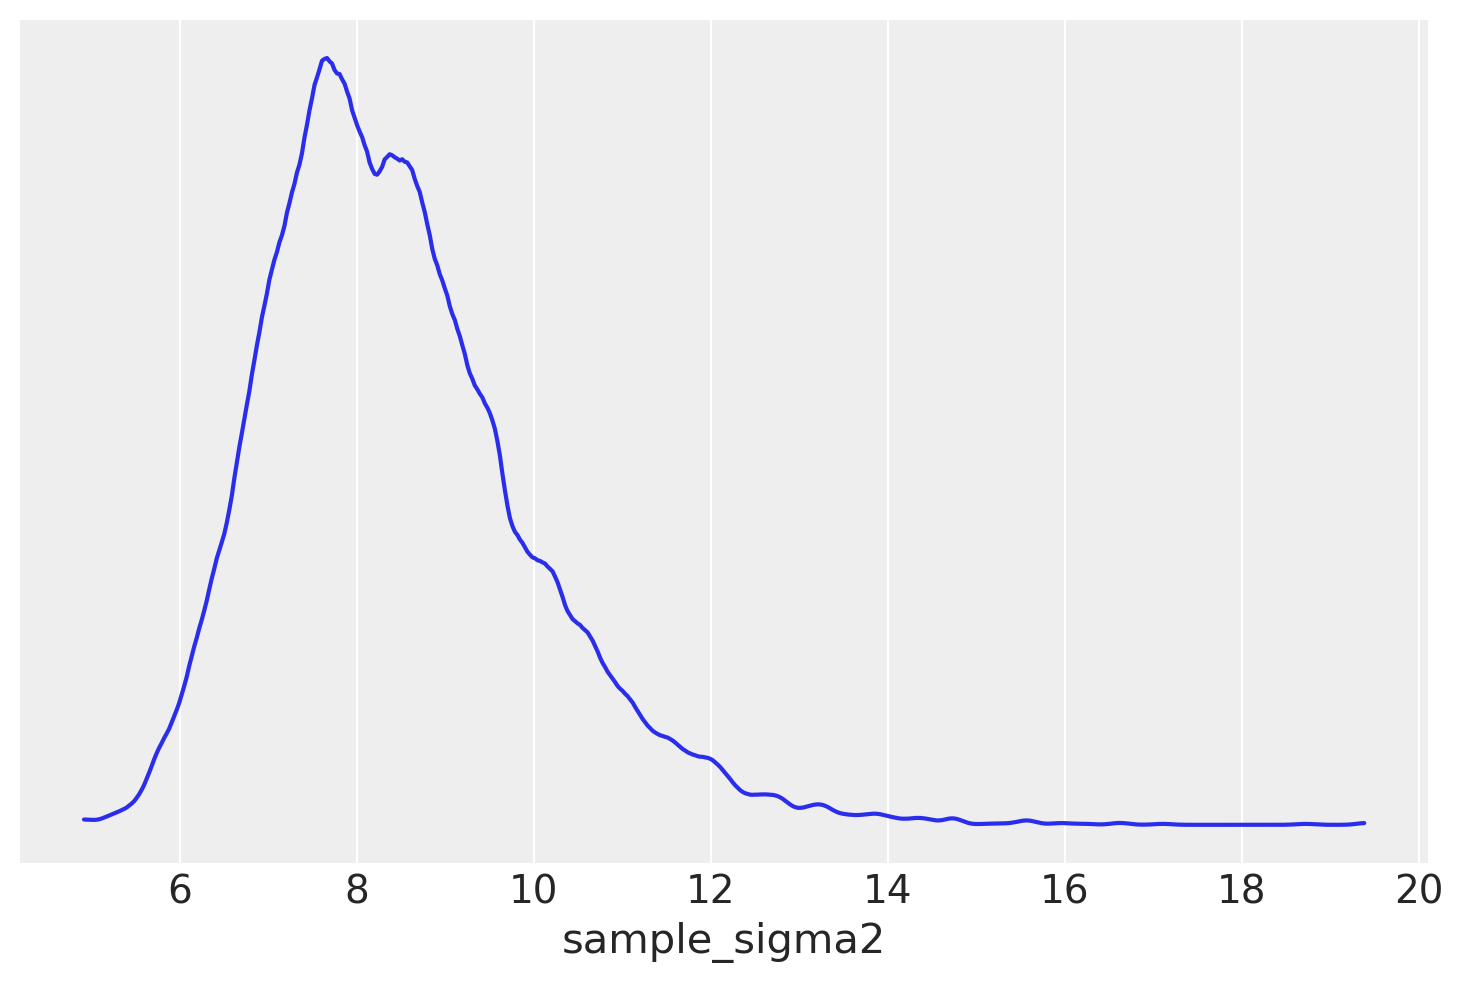

In [28]:
az.plot_kde(sample_sigma2)
plt.xlabel("sample_sigma2")
plt.yticks([])

In [29]:
d = pd.read_csv("Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]

In [30]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: モデルの再定義</font></h3>


* pm.Model()でベイズモデルをm4.1として再び定義しなおす。
* muは正規分布、sigmaは一様分布、heightは正規分布に従い、
* パラメータはコードのように定める。

### Code4.28

以下は元のnotebookに書かれていた説明の和訳です。  
  
「私たちは、McElreath先生が行ったように、二次近似を使用できます。ただ、PyMCを使用してモデルからサンプリングすることは非常に単純で、「サンプラーメソッド」を使用してできます。最も一般的なサンプラーメソッドは、マルコフ連鎖モンテカルロ法（MCMC）ファミリーのものです（詳細は「統計的再考」のセクション2.4.3および第8章を参照）。

PyMCにはさまざまなサンプラーがあります。一部のサンプラーは、特定のタイプの変数(と問題)に適しています。今のところ、PyMCにサンプラーの選択を任せることにします。PyMCはまた、シミュレーションのための合理的な初期値を提供しようとします。デフォルトでは、PyMCはSTANの 'jitter+adapt_diag' と同じ適応手法を使用し、単位質量行列から始めて、チューニングサンプルの分散に基づいて対角行列を適応させます。」

In [31]:
with m4_1:
    trace_4_1 = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

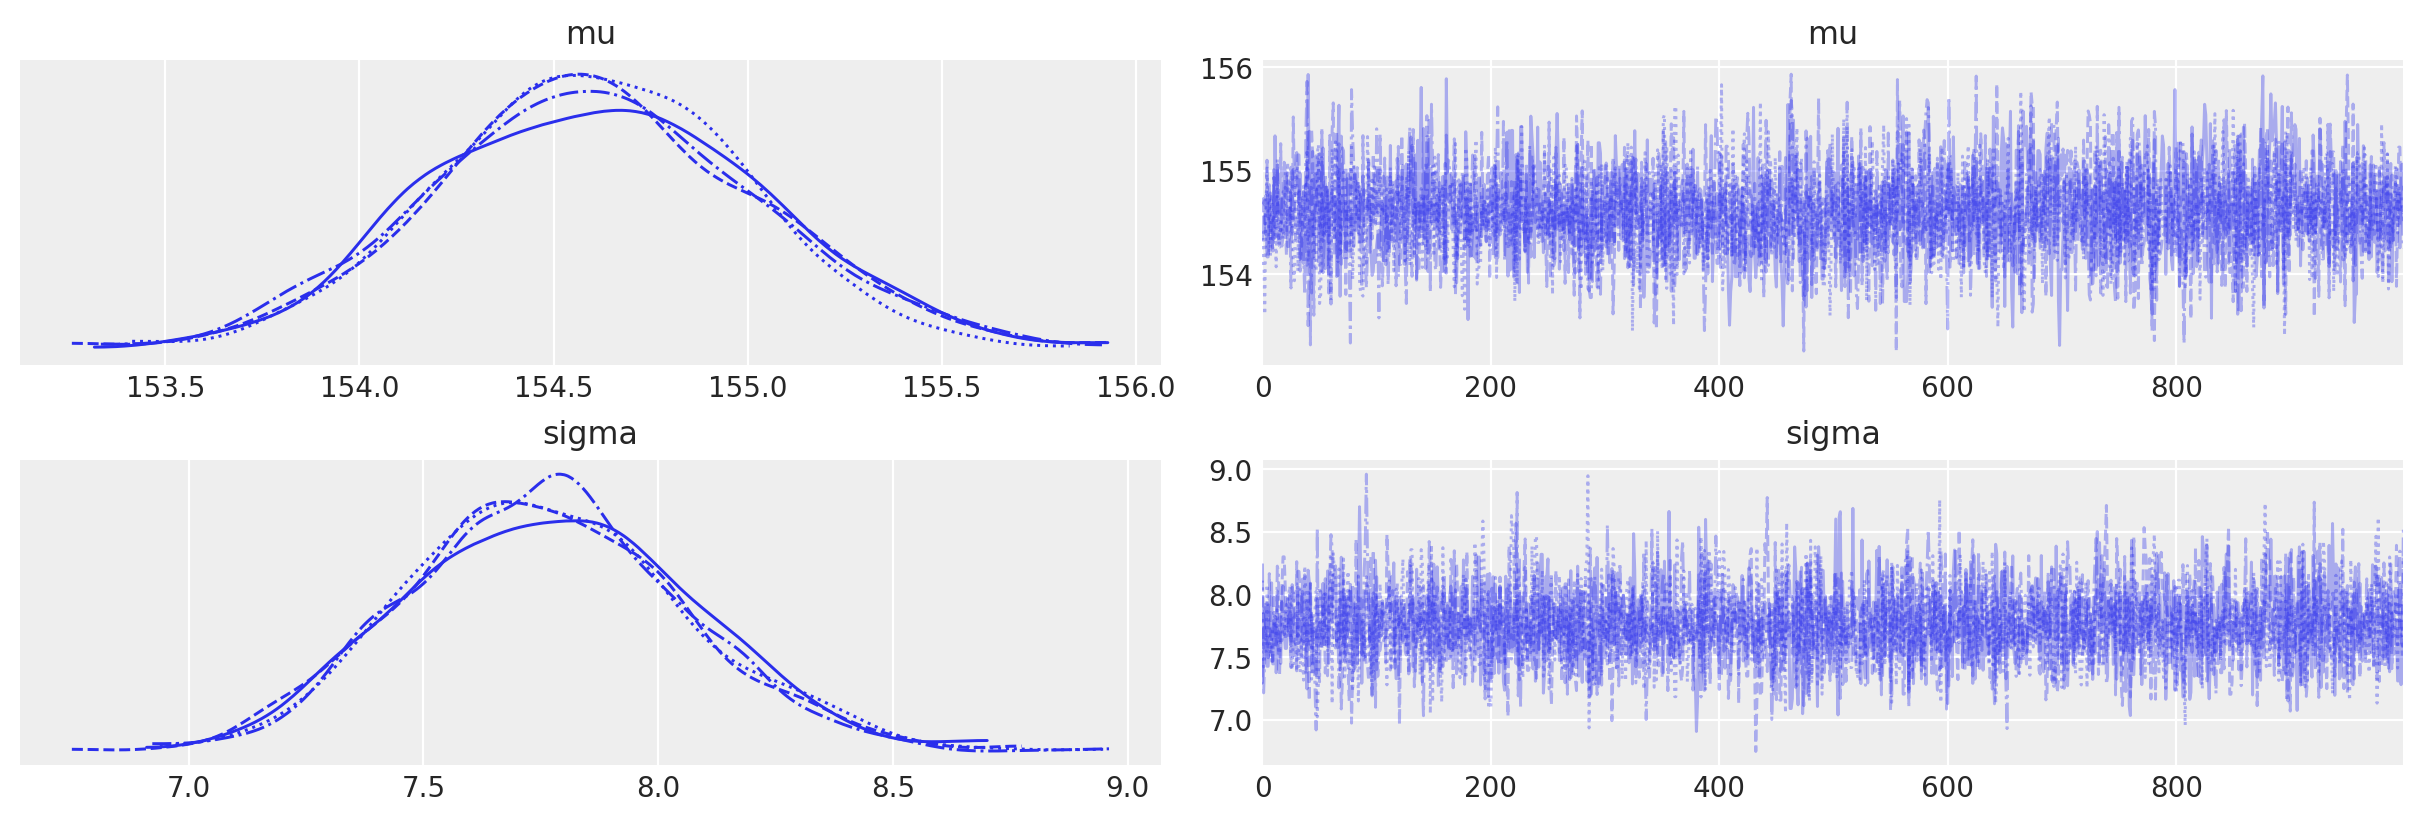

In [39]:
az.plot_trace(trace_4_1)

In [33]:
az.summary(trace_4_1, round_to=2, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.62,0.43,153.95,155.31
sigma,7.77,0.29,7.29,8.22


### Code4.30

In [34]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_1 = pm.sample(1000,tune=1000)

C:\Users\satyk\AppData\Local\Temp\ipykernel_20212\3284309091.py:2: FutureWarning: The `testval` argument is deprecated; use `initval`.
  mu = pm.Normal("mu", mu=178, sigma=20, testval=d2.height.mean())
C:\Users\satyk\AppData\Local\Temp\ipykernel_20212\3284309091.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


In [35]:
az.summary(trace_4_1, round_to=2, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.61,0.42,153.95,155.30
sigma,7.76,0.30,7.27,8.21


<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes:パラメータの推定4_1(MCMC) </font></h3>


* パラメータの分布を定める。
* testval=d2.height.mean()は初期値を平均に設定していることを表す。

### Code4.31

In [36]:
with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sigma=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_2 = pm.sample(1000, tune=1000)
az.summary(trace_4_2, round_to=2, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
mu,177.86,0.10,177.70,178.02
sigma,24.60,0.93,23.04,26.00


In [40]:
trace_df = az.extract_dataset(trace_4_1).to_dataframe()
trace_df.cov()

C:\Users\satyk\AppData\Local\Temp\ipykernel_20212\1341205868.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  trace_df = az.extract_dataset(trace_4_1).to_dataframe()


,mu,sigma,chain,draw
mu,0.176730,-0.001118,-0.004398,4.638653
sigma,-0.001118,0.088042,-0.006631,1.321492
chain,-0.004398,-0.006631,1.250313,0.000000
draw,4.638653,1.321492,0.000000,83354.088522


In [44]:
np.diag(trace_df.cov())

array([1.75707525e-01, 8.53071980e-02, 1.25031258e+00, 8.33540885e+04])

In [45]:
trace_df.corr()

,mu,sigma,chain,draw
mu,1.000000,-0.004094,-3.074252e-02,4.894125e-03
sigma,-0.004094,1.000000,2.533027e-03,1.026727e-02
chain,-0.030743,0.002533,1.000000e+00,-1.759469e-16
draw,0.004894,0.010267,-1.759469e-16,1.000000e+00


In [46]:
trace_df.drop(columns=['chain', 'draw'], inplace=True)

In [47]:
trace_df.head()

mu     sigma
chain draw                      
0     0     154.658793  8.152759
      1     154.419624  7.420251
      2     155.096877  8.119837
      3     154.607175  7.429091
      4     154.303909  7.287669

In [48]:
trace_4_1.posterior["sigma"][0][:10]

<xarray.DataArray 'sigma' (draw: 10)>
array([8.15275936, 7.42025076, 8.11983735, 7.42909072, 7.28766866,
       8.18423664, 8.10700934, 8.14166777, 7.90524345, 7.66023875])
Coordinates:
    chain    int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 9

In [49]:
az.summary(trace_4_1,round_to=2,kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.60,0.42,153.91,155.24
sigma,7.77,0.29,7.29,8.21


In [50]:
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(),size=10)

array([[155.44666459,   7.73231214],
       [154.22714797,   8.02444459],
       [154.43795654,   8.13254008],
       [154.55883445,   7.84034408],
       [154.50639264,   7.38072702],
       [155.05618546,   7.51462706],
       [154.72327047,   7.86250164],
       [155.17525358,   7.9214265 ],
       [154.32525441,   7.74971672],
       [154.75035404,   8.06572487]])

Text(0, 0.5, 'weight')

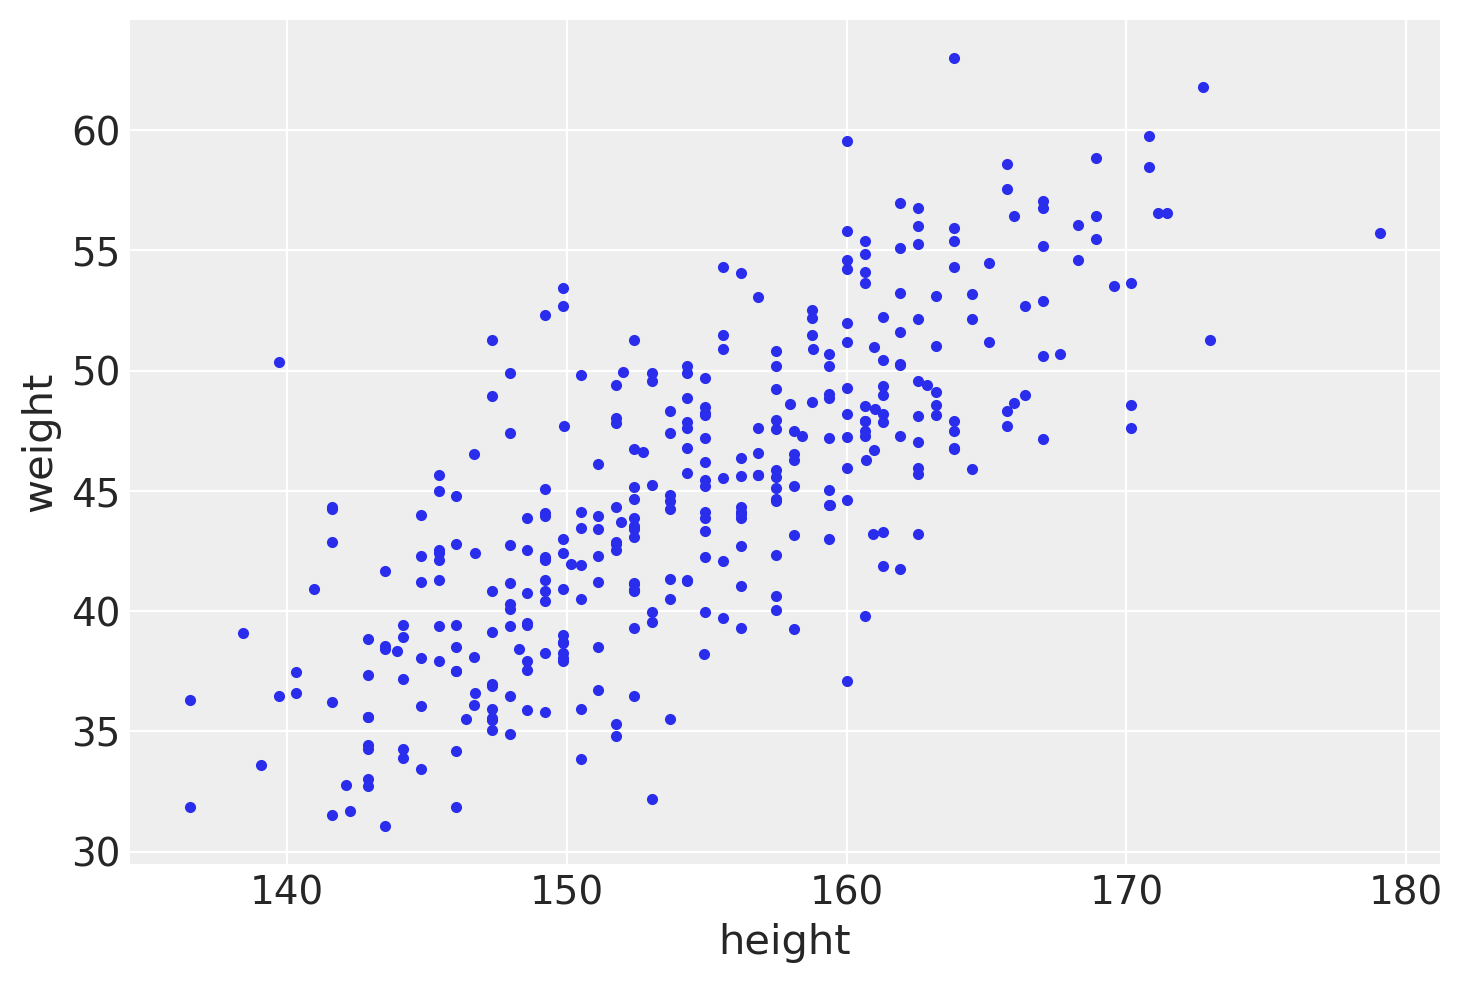

In [52]:
plt.plot(d2.height, d2.weight, ".")
plt.xlabel("height")
plt.ylabel("weight")

In [68]:
height_rng = np.random.default_rng(42)

N = 100
a = stats.norm.rvs(178, 20, N)
b = stats.norm.rvs(0, 10, N)

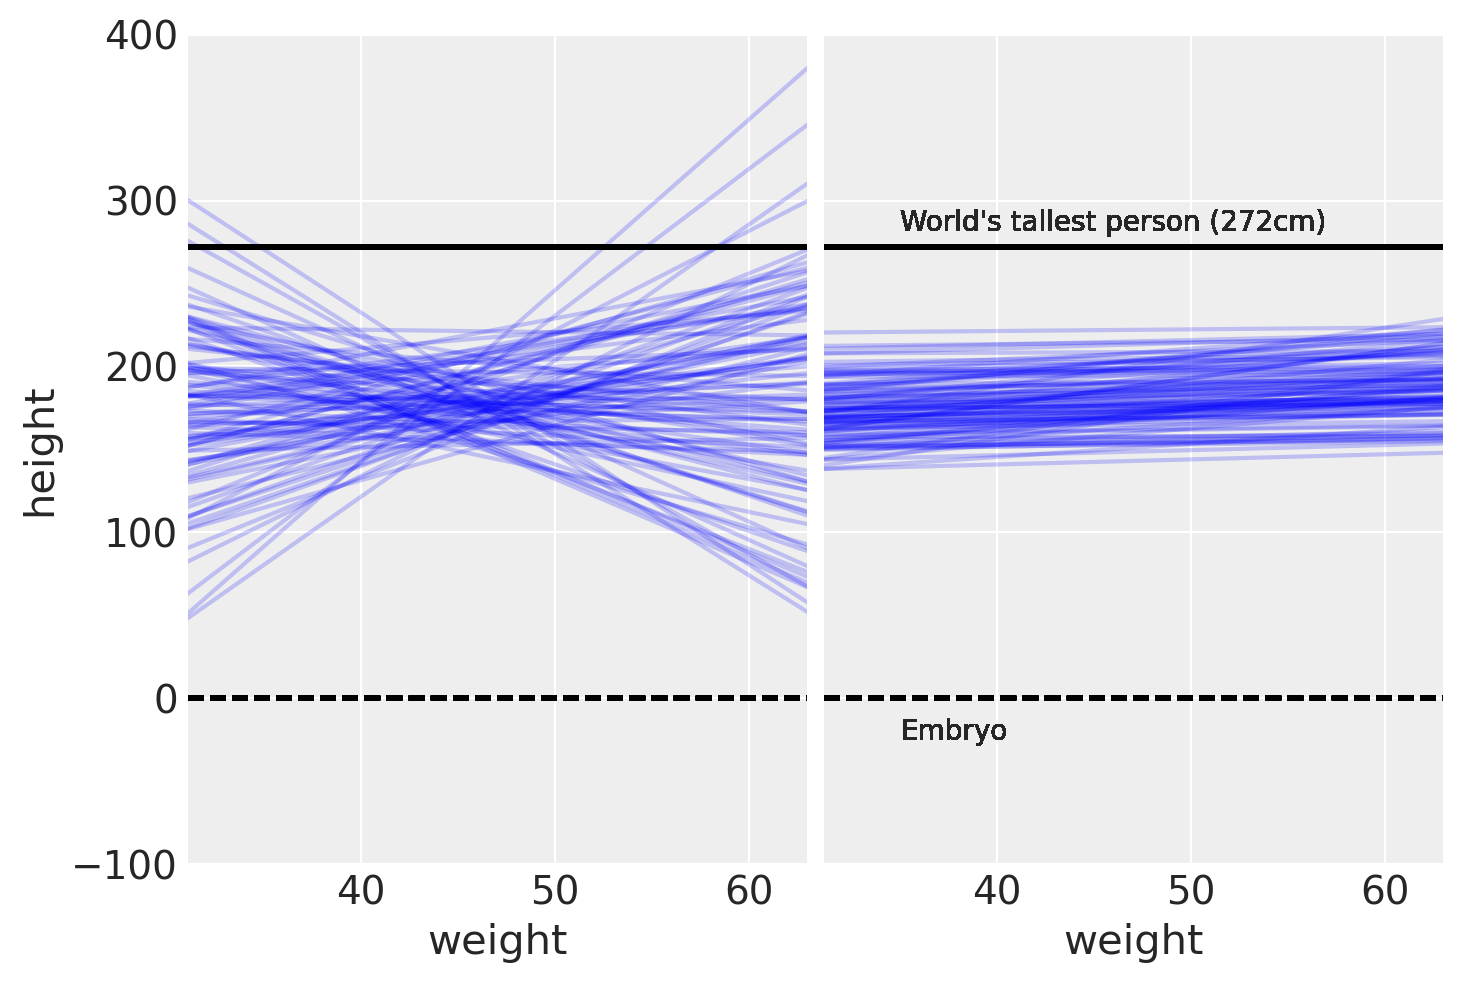

In [64]:
_, ax = plt.subplots(1, 2, sharey=True)
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(),N)
for i in range(N):
    ax[0].plot(a[i]+b[i]*(x-xbar), "b", alpha=0.2)
    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100,400)
    ax[0].axhline(0, c="k",ls="--")
    ax[0].axhline(272,c="k")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")

b = stats.lognorm.rvs(s=1, scale=1, size=100)
for i in range(N):
    ax[1].plot(a[i]+b[i]*(x-xbar), "b", alpha=0.2)
    ax[1].set_xlim(d2.weight.min(),d2.weight.max())
    ax[1].set_ylim(-100,400)
    ax[1].axhline(0, c="k",ls="--", label="embryo")
    ax[1].axhline(272, c="k")
    ax[1].set_xlabel("weight")
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s="Embryo")

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes:モデルのプロット </font></h3>


* 上のコードは以下のようにより簡潔に書ける
```
  _, ax = plt.subplots(1, 2, sharey=True)
  xbar = d2.weight.mean()
  x = np.linspace(d2.weight.min(), d2.weight.max(), N)

  for i in range(N):
    ax[0].plot(a[i] + b[i] * (x - xbar), "b", alpha=0.2)

  ax[0].set_xlim(d2.weight.min(), d2.weight.max())
  ax[0].set_ylim(-100, 400)
  ax[0].axhline(0, c="k", ls="--")
  ax[0].axhline(272, c="k")
  ax[0].set_xlabel("weight")
  ax[0].set_ylabel("height")
```
* 下のコードは以下のようにより簡潔に書ける
```
  b = stats.lognorm.rvs(s=1, scale=1, size=100)
  for i in range(N):
    ax[1].plot(a[i] + b[i] * (x - xbar), "b", alpha=0.2)

  ax[1].set_xlim(d2.weight.min(), d2.weight.max())
  ax[1].set_ylim(-100, 400)
  ax[1].axhline(0, c="k", ls="--", label="embryo")
  ax[1].axhline(272, c="k")
  ax[1].set_xlabel("weight")
  ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
  ax[1].text(x=35, y=-25, s="Embryo")
```
*

### Code4.42

In [71]:
with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (d2.weight.values-xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


In [72]:
with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + np.exp(b)*(d2.weight.values-xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_3b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


In [73]:
az.summary(trace_4_3, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
a,154.605,0.277,154.160,155.035
b,0.903,0.041,0.838,0.969
sigma,5.105,0.199,4.787,5.413


### Code 4.45